# 1) Setup

## 1a) Library functions

In [20]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from datetime import datetime, timedelta
from copy import copy
import os
import random

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn as skl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
import shap
import xgboost as xgb

#Tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K

#LTR tensorflow
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar

#tensorflow rankings
import tensorflow_ranking as tfr

# Set random seed for reproducability
#tensorflow.random.set_seed(0)

print("done")

done


## 1b) Helper functions

In [21]:
def ListUnion(l1, l2):
    union = list(set(l1) | set(l2))
    return union

In [22]:
def regression_analysis(X,Y, ylabel = "Return for our strategy"):
    #remove nans
    #X = X[~np.isnan(Y)]
    #Y = Y[~np.isnan(Y)]
    #X = X[~np.isnan(X)]
    #Y = Y[~np.isnan(X)]
    res = pd.DataFrame(index = range(len(X)))
    res["X"] = X
    res["Y"] = Y
    res = res.dropna(how = "any")
    X = np.array(res["X"])
    Y = np.array(res["Y"])
    
    #fit OLS
    X2 = sm.add_constant(X)
    model = sm.OLS(Y, X2).fit() ## sm.OLS(output, input)
    coeff = [model.params[1],model.params[0]]
    
    #correlation
    corr = sp.stats.pearsonr(X,Y)
    
    #plot
    plt.scatter(X,Y,marker = ".");
    x_plot = np.arange(X.min(),X.max(),0.01)
    plt.plot(x_plot,np.polyval(coeff,x_plot),color = "orange");
    plt.xlabel("Return for index")
    plt.ylabel(ylabel)
    title = "alpha = %.5f  |  beta = %.5f, \n pval_alpha = %.5f  |  correlation = %.5f" % (model.params[0],model.params[1],model.pvalues[0],corr[0])
    #title = "alpha = %.5f  |  beta = %.5f  |  corr = %.5f" % (model.params[0],model.params[1],corr[0])
    plt.title(title)
    return;


In [23]:
def get_TrainTest(df_train,df_test,features, target, is_regression = True, is_ltr = False):
    """
    Get Train & Test matrices in correct format
    """
    x_train = df_train[features].values
    y_train = df_train[target].values
    x_test = df_test[features].values
    y_test = df_test[target].values

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train =y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    #change data type if classification
    if is_regression == False or is_regression == "brier":
        y_train = y_train > 0  #classification
        y_test = y_test > 0    #classification
        y_train = utils.to_categorical(y_train)
        y_test = utils.to_categorical(y_test)
    print ('Training Set: %d, Test Set: %d\n' % (len(x_train), len(x_test)))
    
    #provide queries if ltr
    if is_ltr:
        #queries
        q_train = df_train["month"].values
        q_test = df_test["month"].values
        #reformat output for ltr as rankings
        y_train = df_train.groupby("month")[target].rank("dense", ascending = False).values
        y_test = df_test.groupby("month")[target].rank("dense", ascending = False).values
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')
        return x_train, y_train, q_train, x_test, y_test, q_test
    else:
        return x_train, y_train, x_test, y_test

In [24]:
def get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = True, is_ltr = False):
    """
    Get Train & Test matrices in correct format
    """
    x_train = df_train[features].values
    y_train = df_train[target].values
    x_test = df_test[features].values
    y_test = df_test[target].values
    x_validate = df_validate[features].values
    y_validate = df_validate[target].values

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_validate = x_validate.astype('float32')
    y_train =y_train.astype('float32')
    y_test = y_test.astype('float32')
    y_validate =y_validate.astype('float32')
    
    #change data type if classification
    if is_regression == False or is_regression == "brier":
        y_train = y_train > 0  #classification
        y_test = y_test > 0    #classification
        y_validate = y_validate > 0    #classification
        y_train = utils.to_categorical(y_train)
        y_test = utils.to_categorical(y_test)
        y_validate = utils.to_categorical(y_validate)
    print ('Training Set: %d, Test Set: %d, Validation Set: %d \n' % (len(x_train), len(x_test), len(x_validate)))
    
    #provide queries if ltr
    if is_ltr:
        #queries
        q_train = df_train["month"].values
        q_test = df_test["month"].values
        q_validate = df_validate["month"].values
        #reformat output for ltr as rankings
        y_train = df_train.groupby("month")[target].rank("dense", ascending = False).values
        y_test = df_test.groupby("month")[target].rank("dense", ascending = False).values
        y_validate = df_validate.groupby("month")[target].rank("dense", ascending = False).values
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')
        y_validate = y_validate.astype('int')
        return x_train, y_train, q_train, x_test, y_test, q_test, x_validate, y_validate, q_validate
    else:
        return x_train, y_train, x_test, y_test, x_validate, y_validate

In [25]:
def custom_brier(y_actual,y_pred):
    brier_score = tf.reduce_mean((y_actual - y_pred) ** 2, axis=1)
    return brier_score

In [26]:
def create_NN(hidden, dropout, input_dim, is_regression = True, is_search = False, std =  0.01, seed = 1, learning_rate = 0.1):
    """
    Create MLP regression / classifier with random initialisation, Batch Normalisation & dropout
    """
    model = Sequential()
    #input layer
    model.add(Dense(hidden[0], input_dim=input_dim, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, seed = seed))
    #hidden layers
    for i in range(1,len(hidden)):
        model.add(Dense(hidden[i], input_dim=hidden[i-1], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout, seed = seed))
    #output layer
    if is_regression:
        model.add(Dense(1, input_dim=hidden[-1], activation=None,kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    else:
        model.add(Dense(2, input_dim=hidden[-1], activation="softmax",kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    
    if is_search:
        opt = optimizers.Adam(learning_rate=learning_rate)
        if is_regression == True:
            model.compile(optimizer = opt, loss = 'mean_squared_logarithmic_error', metrics = ['mean_squared_logarithmic_error'])
        elif is_regression == "brier":
            model.compile(optimizer = opt, loss = custom_brier, metrics = ['accuracy'])
        else:
            model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
            
    return model
    

In [27]:
def train_NN(model, x_train, y_train, x_test, y_test, learning_rate = 0.1, is_regression = True,is_brier = False, num_epochs = 50, plot_graph = False):
    """
    Train NN with Adam optimiser
    """
    #create optimiser
    opt = optimizers.Adam(learning_rate=learning_rate)
    if is_regression:
        loss_fn = keras.losses.MeanSquaredError()
    else:
        loss_fn = keras.losses.CategoricalCrossentropy()
        if is_regression == "brier":
            loss_fn = custom_brier
    model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=[loss_fn])
    #fit model
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=500, validation_data=(x_test, y_test), verbose = 0)

    #plot fitting results
    if plot_graph:
        epoch_nums = range(1,num_epochs+1)
        training_loss = history.history["loss"]
        validation_loss = history.history["val_loss"]
        plt.plot(epoch_nums, training_loss)
        plt.plot(epoch_nums, validation_loss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    
    return model, history

In [28]:
def get_Matrices(model, x_test, df_test, company_name = "TICKER", is_regression = True, pct = 0.1, is_short = False, max_ret = 10):
    """
    create return & weight matrices
    """
    # predict outputs
    model_output = model.predict(x_test)
    if is_regression == False:
        model_output = model_output[:,1]
    #map to original test dataframe for price data
    predictions = df_test.iloc[:,:5]
    predictions["pred"] = model_output
    
    #rank predictions
    predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
    rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(predictions, values="pred_target", index=["month"],
                    columns=[company_name])
    
    #backfill if returns are suspiciously high
    returns_matrix[returns_matrix > max_ret] = returns_matrix.shift()
    return returns_matrix, weight_matrix, rank_table, model_output

In [29]:
def get_Matrices_LTR(model_output, df_test, query_test, pair_test, company_name = "TICKER", pct = 0.1, is_short = False, max_ret = 10, discretise = True):
    """
    create return & weight matrices
    """
    #convert to rankings
    if discretise:
        predictions = np.sign(model_output-0.5)
    else:
        predictions = model_output
    n_outputs = len(predictions)
    df_pairs = pd.DataFrame(index = range(len(predictions)))
    df_pairs[str(df_test.columns[0])] = list(df_test.iloc[pair_test[:n_outputs,0],0])
    df_pairs["month"] = query_test[:n_outputs]
    df_pairs["pred"] = predictions[:n_outputs]
    df_pairs["first"] = pair_test[:n_outputs,0]
    df_pairs["second"] = pair_test[:n_outputs,1]
    df_ranks = df_pairs.groupby(["month",df_train.columns[0]])["pred"].sum().to_frame().reset_index()
    df_ranks["rank"] = df_ranks.groupby("month")["pred"].rank("dense", ascending = False)
    df_ranks = df_ranks.merge(df_test[[company_name,"month","pred_target"]],on  =[company_name,"month"], how = "left")
    rank_table = pd.pivot_table(df_ranks, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(df_ranks, values="pred_target", index=["month"],
                    columns=[company_name])
    
    #backfill if returns are suspiciously high
    returns_matrix[returns_matrix > max_ret] = returns_matrix.shift()
    return returns_matrix, weight_matrix, rank_table, model_output

In [30]:
def turnover_cost(w, k):
    """
    Calculate transaction costs. k is in bps, w is a weight matrix
    """
    k = k/10000  #convert to bps
    w.fillna(value = 0, inplace=True)
    t_cost = w.diff(1).abs().sum(axis = 1) * k
    t_cost[0] = k
    return t_cost

In [31]:
def calc_returns(returns_matrix, weight_matrix, k = 3):
    """
    Calculate returns & cumulative returns, including transaction costs of k bps.
    """
    #equal weighted
    if isinstance(weight_matrix,str):
        if weight_matrix == "equal":
            rets = returns_matrix.mean(axis = 1)
            rets.index = pd.to_datetime(rets.index)
            #rets.index = rets.index.to_timestamp()   #convert periods to timestamps
            cumrets = (1+rets).cumprod()
        else:
            raise ValueError("Invalid string argument. Must be equal")
    else:
        #calculate returns using weight matrix
        rets = (weight_matrix*returns_matrix.fillna(0)).sum(axis = 1)
        rets = rets - turnover_cost(weight_matrix, k)
        rets.index = pd.to_datetime(rets.index)
        #rets.index = rets.index.to_timestamp()   #convert periods to timestamps
        #calculate cumulative returns
        cumrets = (1+rets).cumprod()
    return rets, cumrets

In [32]:
"""
def calc_mar(rets, periods_per_year = 12):
    #rets = monthly returns
    n = len(rets)/periods_per_year   #no. of years
    cumrets = (1+rets).cumprod()   #cumulative returns
    #scale to average annual return and volatility
    mar = cumrets[-1]**(1/n) - 1
    return mar
"""

def calc_mar(rets, periods_per_year = 12):
    mar = ((1+rets.mean())**12-1)
    return mar

In [33]:
"""
def calc_sharpe(rets, periods_per_year = 12):
    #rets = monthly returns
    n = len(rets)/periods_per_year   #no. of years
    cumrets = (1+rets).cumprod()   #cumulative returns
    #scale to average annual return and volatility
    sharpe = (cumrets[-1]**(1/n) - 1)/(np.std(rets) * np.sqrt(periods_per_year))
    return sharpe
"""
def calc_sharpe(rets, periods_per_year = 12):
    sharpe = ((1+rets.mean())**12-1)/ ( rets.std() * np.sqrt(periods_per_year) )
    return sharpe

In [34]:
def calc_sortino(rets, periods_per_year = 12):
    sortino = ((1+rets.mean())**12-1)/(rets[rets<0].std() * np.sqrt(periods_per_year) )
    return sortino

In [35]:
def calc_mdd(returns, verbose = False):
    #maximum drawdown
    cum_rets = (1 + returns).cumprod()
    max_cumret = cum_rets.cummax()  #max previous cumret
    dd = 1 - cum_rets/max_cumret   #all drawdowns
    
    #visual check
    if verbose:
        print(cum_rets[np.argmax(dd)-2:np.argmax(dd)+2])
        print(max_cumret[np.argmax(dd)-2:np.argmax(dd)+2])
        
    #ret
    return np.max(dd), np.argmax(dd)

In [36]:
def feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=1, is_regression = True):
    if is_regression:
        scoring =  "neg_mean_squared_error"
    else:
        #neg_log_loss is technically correct, but not worth rewriting permutation importance to replace predict_proba with predict
        #scoring = "neg_log_loss"
        scoring =  "neg_mean_squared_error"
    result = permutation_importance(model, x_test, y_test, n_repeats=n_repeats, random_state=random_state, scoring = scoring)
    sorted_idx = result.importances_mean.argsort()
    labels = np.array(features)

    plt.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx]
    )
    plt.title("Permutation Importances (test set)")

    plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    
    features_pi = list(labels[result.importances_mean > 0])
    print("Permutation importance > 0:")
    print(features_pi)
    return result, features_pi

In [37]:
def create_pairs(query, doc_features, doc_scores):
    # put data into pairs
    xi = []  #input 1
    xj = []  #input 2
    pij = []      #target
    pair_id = []    #pair
    pair_query_id = []    #pair_query

    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        for pair_idx in combinations(query_idx, 2):

            pair_id.append(pair_idx)
            i = pair_idx[0]
            j = pair_idx[1]
            xi.append(doc_features[i])
            xj.append(doc_features[j])
            pair_query_id.append(q)

            if doc_scores[i] == doc_scores[j]:
                _pij = 0.5
            elif doc_scores[i] > doc_scores[j]:
                _pij = 1
            else: 
                _pij = 0
            pij.append(_pij)

    xi = np.array(xi)
    xj = np.array(xj)
    pij = np.array(pij)
    pair_query_id = np.array(pair_query_id)
    
    return xi, xj, pij, pair_id, pair_query_id

## 1c) Read data

In [38]:
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_fillna.pkl")
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_bloomberg.pkl")

#df_nn = pd.read_pickle("FinalMembers/df_NeuralNetworkFeatures.pkl")
df_nn = pd.read_pickle("FinalMembers/df_NNdata_withMACD.pkl")
df_nn

,PERMNO,month,pred_target,mcap,gsector,debt_assets,de_ratio,evm,pe_exi,roe,...,return_12M,macd_3_16,macd_3_24,macd_3_32,macd_6_16,macd_6_24,macd_6_32,macd_9_16,macd_9_24,macd_9_32
0,10078.0,2002-01,-0.209108,3.487959e+10,7.0,0.411,0.697,27.293,500.000,0.028,...,-0.647934,-0.262929,-0.231501,-0.219760,-0.221719,-0.205719,-0.199555,-0.202827,-0.193608,-0.189803
1,10078.0,2002-02,0.036428,2.764405e+10,7.0,0.415,0.710,42.961,-189.110,-0.053,...,-0.571823,-0.216646,-0.194353,-0.186169,-0.188457,-0.176734,-0.172316,-0.174603,-0.167914,-0.165263
2,10078.0,2002-03,-0.072562,2.865106e+10,7.0,0.415,0.710,42.961,-196.000,-0.053,...,-0.426154,-0.177402,-0.162822,-0.157666,-0.160040,-0.152124,-0.149307,-0.150313,-0.146022,-0.144473
3,10078.0,2002-04,-0.157702,2.657208e+10,7.0,0.415,0.710,42.961,-181.780,-0.053,...,-0.522195,-0.166721,-0.155574,-0.151787,-0.153857,-0.147718,-0.145694,-0.145811,-0.142731,-0.141772
4,10078.0,2002-05,-0.272859,2.236680e+10,7.0,0.418,0.719,84.523,-119.830,-0.070,...,-0.581663,-0.167745,-0.156779,-0.153132,-0.155035,-0.149098,-0.147232,-0.146903,-0.144096,-0.143314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117326,93436.0,2021-07,0.070605,6.803383e+11,3.0,0.593,1.574,104.366,460.172,0.080,...,1.401521,0.345490,0.653761,0.613442,0.806785,0.473680,0.393620,0.452413,0.346973,0.313824
117327,93436.0,2021-08,0.054042,7.283738e+11,3.0,0.554,1.325,108.001,383.188,0.122,...,0.476400,0.432947,0.573072,0.470146,0.635574,0.390181,0.329680,0.383073,0.298225,0.271048
117328,93436.0,2021-09,0.436530,7.677368e+11,3.0,0.554,1.325,108.001,403.896,0.122,...,0.807602,0.465906,0.445869,0.378184,0.506212,0.347343,0.301829,0.349888,0.281072,0.257824
117329,93436.0,2021-10,0.027612,1.118751e+12,3.0,0.554,1.325,108.001,492.500,0.122,...,1.870836,0.357049,0.351621,0.320781,0.417091,0.312689,0.272393,0.319155,0.253568,0.229752


In [49]:
df_nn.sort_values(["month","PERMNO"])[["PERMNO","month","pred_target","return_1M","return_3M","return_6M","return_9M","return_12M"]]

,PERMNO,month,pred_target,return_1M,return_3M,return_6M,return_9M,return_12M
0,10078.0,2002-01,-0.209108,-0.125203,0.060099,-0.339472,-0.371494,-0.647934
96,10104.0,2002-01,-0.037080,0.249819,0.272861,-0.045354,0.068069,-0.407382
335,10107.0,2002-01,-0.084288,-0.038340,0.095614,-0.037467,-0.059631,0.043357
611,10137.0,2002-01,0.050441,-0.091386,-0.088900,-0.218672,-0.335592,-0.248146
720,10138.0,2002-01,0.059340,0.082062,0.359984,-0.000358,0.096049,-0.018431
...,...,...,...,...,...,...,...,...
117131,93096.0,2021-11,0.065657,-0.000993,-0.005340,0.094404,0.177600,0.020067
117169,93132.0,2021-11,0.082172,-0.012577,0.053849,0.519676,0.966894,1.695043
117222,93246.0,2021-11,-0.164562,-0.155087,-0.036021,0.281453,0.278187,0.953799
117318,93429.0,2021-11,0.011323,-0.019100,0.025921,0.167227,0.317732,0.434037


In [20]:
df_nn.columns

Index(['PERMNO', 'month', 'pred_target', 'mcap', 'gsector', 'debt_assets',
       'de_ratio', 'evm', 'pe_exi', 'roe', 'npm', 'ps', 'ptb', 'pcf',
       'aftret_invcapx', 'CPI', 'PMI', 'PPI', 'FedFundsTargetRate', 'GDP',
       'MedianHomeSalesPrice', 'PrivateHousingStarts', 'NonFarmPayrolls',
       'Unemployment', 'MEDPTG', 'PCTUP4W', 'PCTDOWN4W', 'volume', 'gsector',
       'return_1M', 'return_3M', 'return_6M', 'return_9M', 'return_12M',
       'macd_3_16', 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24',
       'macd_6_32', 'macd_9_16', 'macd_9_24', 'macd_9_32'],
      dtype='object')

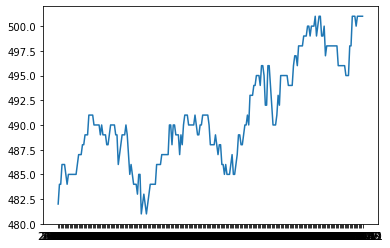

In [21]:
plt.plot(sorted(df_nn["month"].unique()),df_nn.groupby("month").apply(len))

In [22]:
np.isinf(df_nn.iloc[:,2:]).sum()

pred_target             0
mcap                    0
gsector                 0
debt_assets             0
de_ratio                0
evm                     0
pe_exi                  0
roe                     0
npm                     0
ps                      0
ptb                     0
pcf                     0
aftret_invcapx          0
CPI                     0
PMI                     0
PPI                     0
FedFundsTargetRate      0
GDP                     0
MedianHomeSalesPrice    0
PrivateHousingStarts    0
NonFarmPayrolls         0
Unemployment            0
MEDPTG                  0
PCTUP4W                 0
PCTDOWN4W               0
volume                  0
gsector                 0
return_1M               0
return_3M               0
return_6M               0
return_9M               0
return_12M              0
macd_3_16               0
macd_3_24               0
macd_3_32               0
macd_6_16               0
macd_6_24               0
macd_6_32               0
macd_9_16   

In [23]:
df_nn[df_nn["PERMNO"] == 10107]

,PERMNO,month,pred_target,mcap,gsector,debt_assets,de_ratio,evm,pe_exi,roe,...,return_12M,macd_3_16,macd_3_24,macd_3_32,macd_6_16,macd_6_24,macd_6_32,macd_9_16,macd_9_24,macd_9_32
335,10107.0,2002-01,-0.084288,3.431264e+11,7.0,0.200,0.250,22.210,27.700,0.133,...,0.043357,-0.021573,-0.087655,-0.154461,-0.067483,-0.171132,-0.278870,-0.124257,-0.272265,-0.400114
336,10107.0,2002-02,0.033768,3.159241e+11,7.0,0.204,0.257,23.933,26.761,0.125,...,-0.011186,-0.059602,-0.122392,-0.189103,-0.084116,-0.180793,-0.297302,-0.126337,-0.274670,-0.473829
337,10107.0,2002-03,-0.133477,3.266394e+11,7.0,0.204,0.257,23.933,27.665,0.125,...,0.102812,-0.079586,-0.167956,-0.257638,-0.130215,-0.289868,-0.494576,-0.185413,-0.432664,-0.787677
338,10107.0,2002-04,-0.025832,2.830405e+11,7.0,0.204,0.257,23.933,23.972,0.125,...,-0.228634,-0.139881,-0.224125,-0.299000,-0.241986,-0.472311,-0.707960,-0.331870,-0.767282,-1.240214
339,10107.0,2002-05,0.074445,2.757012e+11,7.0,0.207,0.262,24.626,22.329,0.129,...,-0.264093,-0.152124,-0.228622,-0.295343,-0.269287,-0.483383,-0.656285,-0.427333,-0.906361,-1.203284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,10107.0,2021-07,0.061528,2.145821e+12,7.0,0.583,1.400,22.727,38.816,0.460,...,0.403029,0.337336,0.330620,0.317353,0.368097,0.331072,0.309976,0.344169,0.308511,0.291020
570,10107.0,2021-08,-0.066119,2.268595e+12,7.0,0.575,1.351,26.222,37.501,0.470,...,0.350790,0.305822,0.297718,0.285770,0.334338,0.301032,0.281972,0.313511,0.281243,0.265149
571,10107.0,2021-09,0.176291,2.118598e+12,7.0,0.575,1.351,26.222,35.021,0.470,...,0.352641,0.257382,0.267799,0.266827,0.314977,0.296588,0.284543,0.309468,0.287506,0.275937
572,10107.0,2021-10,-0.001236,2.489796e+12,7.0,0.575,1.351,26.222,41.195,0.470,...,0.652867,0.317234,0.309192,0.296466,0.336460,0.303504,0.285049,0.312647,0.281988,0.266999


In [24]:
(1+ df_nn[df_nn["PERMNO"] == 10107]["pred_target"]).cumprod()

335     0.915712
336     0.946634
337     0.820280
338     0.799090
339     0.858579
         ...    
569    14.992080
570    14.000818
571    16.469037
572    16.448681
573    16.733786
Name: pred_target, Length: 239, dtype: float64

In [25]:
rets_temp = (df_nn[df_nn["PERMNO"] == 10107]["pred_target"])
rets_temp.mean()

0.014015652719665275

In [26]:
np.sqrt(12)*rets_temp.mean()/rets_temp[rets_temp<0].std()

1.2368365225656015

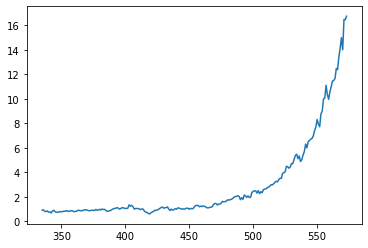

In [27]:
plt.plot((1+ df_nn[df_nn["PERMNO"] == 10107]["pred_target"]).cumprod())

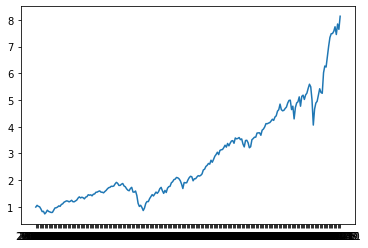

In [28]:
plt.plot((1+df_nn.groupby("month")["pred_target"].mean()).cumprod())

## 1d) Separate data into 5-year "chunks"

In [41]:
#set seed
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#portfolio params
k = 5                #transaction costs in bps
pct = 0.1            #proportion of the portfolio long
is_short = False     #whether to use long-short portfolio

print("done")

done


In [42]:
df_train = df_nn[(df_nn["month"]>= "2002-01") & (df_nn["month"]<= "2006-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2007-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_validate = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


# 2) MLP Classification

In [84]:
#model params
#hidden = [300,300,50]
#dropout = 0.3
hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.1
is_regression = False
learning_rate = 0.1
num_epochs = 3

## 2a) All features

Training Set: 29259, Test Set: 46829, Validation Set: 41243 



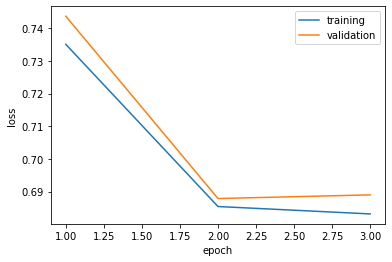

In [85]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)
#for brier
#is_regression = "brier"
#learning_rate = 0.001
#num_epochs = 20

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
clf_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_all.summary())
clf_all, history = train_NN(clf_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

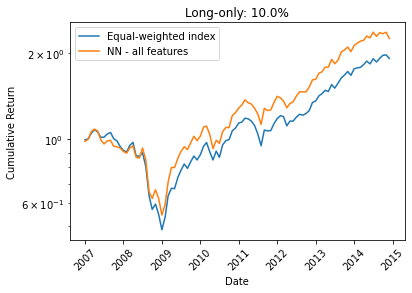

In [91]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d

returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")
plt.title("Long-only: " + str(pct*100) + "%");

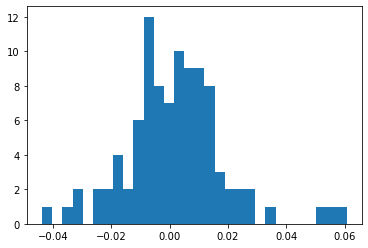

In [34]:
plt.hist(rets - rets_equal, bins  =30);

In [35]:
rank_table

PERMNO,10078.0,10104.0,10107.0,10137.0,10138.0,10145.0,10147.0,10225.0,10299.0,10324.0,...,92618.0,92655.0,92709.0,92778.0,92890.0,92988.0,93002.0,93096.0,93159.0,93422.0
month,,,,,,,,,,,,,,,,,,,,,
2007-01,327.0,378.0,406.0,261.0,407.0,140.0,369.0,114.0,370.0,463.0,...,NaN,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02,429.0,336.0,359.0,275.0,331.0,197.0,301.0,141.0,347.0,241.0,...,NaN,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03,405.0,406.0,401.0,216.0,404.0,319.0,188.0,148.0,393.0,109.0,...,NaN,209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04,424.0,331.0,380.0,338.0,371.0,241.0,353.0,106.0,351.0,242.0,...,NaN,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05,98.0,381.0,359.0,165.0,388.0,219.0,261.0,321.0,386.0,478.0,...,NaN,313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08,NaN,199.0,172.0,NaN,216.0,184.0,188.0,NaN,419.0,NaN,...,242.0,349.0,94.0,150.0,479.0,88.0,442.0,193.0,135.0,15.0
2014-09,NaN,104.0,145.0,NaN,319.0,163.0,140.0,NaN,401.0,NaN,...,64.0,56.0,260.0,263.0,482.0,267.0,389.0,126.0,264.0,303.0
2014-10,NaN,266.0,169.0,NaN,135.0,238.0,192.0,NaN,401.0,NaN,...,276.0,365.0,245.0,143.0,485.0,342.0,434.0,151.0,161.0,25.0


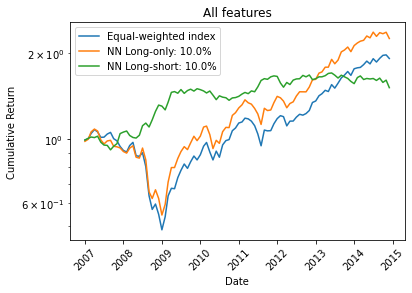

In [35]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d

returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

returns_matrix_short, weight_matrix_short, rank_table_short, model_output_short = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = True, company_name = df_train.columns[0])
rets_short, cumrets_short = calc_returns(returns_matrix_short, weight_matrix = weight_matrix_short, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN Long-only: " + str(pct*100) + "%")
plt.plot(cumrets_short.index, cumrets_short, label = "NN Long-short: " + str(pct*100) + "%")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")
plt.title("All features");
plt.savefig("Figures/TL_TestCLF_Short.png")

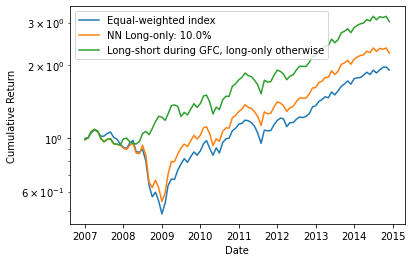

In [53]:
#combined
s1 = cumrets["2007-01-01":"2007-12-01"]
s2 = cumrets_short["2008-01-01":"2009-06-01"]
s3 = cumrets["2009-07-01":"2014-12-01"]
s2 = s2 * s1[-1]
s3 = s3 * s2[-1]
s_combined = pd.concat([s1, s2,s3], axis = 0)
plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN Long-only: " + str(pct*100) + "%")
plt.plot(s_combined.index, s_combined, label = "Long-short during GFC, long-only otherwise")
plt.legend();
plt.xlabel("Date");
#plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")
plt.savefig("Figures/TL_TestCLF_Switch.png")

In [50]:
r1 = rets["2007-01-01":"2007-12-01"]
r2 = rets_short["2008-01-01":"2009-06-01"]
r3 = rets["2009-07-01":"2014-12-01"]
r_combined = pd.concat([r1, r2,r3], axis = 0)
print("NN Switching mar: ", calc_mar(r_combined))
print("NN Switching sharpe: ", calc_sharpe(r_combined))
print("NN Switching sortino: ", calc_sortino(r_combined))
print("NN Switching mdd: ", calc_mdd(r_combined))


NN Switching mar:  0.17608363624127343
NN Switching sharpe:  1.1942729341007743
NN Switching sortino:  2.1721194342681143
NN Switching mdd:  (0.17863094305948835, 55)


In [197]:
#save rankings
model_output = clf_all.predict(x_test)
if is_regression == False or is_regression == "brier":
    model_output = model_output[:,1]
#map to original test dataframe for price data
predictions = df_test.iloc[:,:5]
predictions["pred"] = model_output

#rank predictions
predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
pred_table = pd.pivot_table(predictions, values="pred", index=["month"],
                columns=[df_test.columns[0]])
rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                columns=[df_test.columns[0]])

rank_table.to_csv("FinalRankings/NNwithMACD_Classification_ranks.csv")
pred_table.to_csv("FinalRankings/NNwithMACD_Classification_modeloutputs.csv")

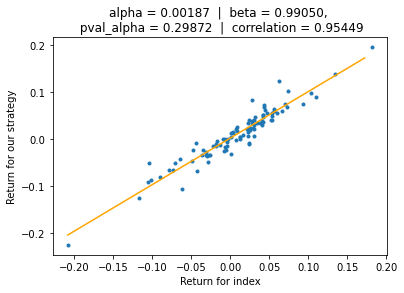

In [36]:
regression_analysis(np.array(rets_equal),np.array(rets))
#plt.savefig("Figures/TL_TestCLF_Alpha.png")

In [199]:
#sharpe ratio
mar = calc_mar(rets)
print("NN mar: ", mar)
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)
sortino = calc_sortino(rets)
print("NN sortino: ", sortino)
mdd = calc_mdd(rets)
print("NN mdd: ", mdd[0])
print()

mar_short = calc_mar(rets_short)
print("NN mar (ls): ", mar_short)
sharpe_short = calc_sharpe(rets_short)
print("NN sharpe (ls): ", sharpe_short)
sortino_short = calc_sortino(rets_short)
print("NN sortino (ls): ", sortino_short)
mdd_short = calc_mdd(rets_short)
print("NN mdd (ls): ", mdd_short[0])
print()

mar_equal = calc_mar(rets_equal)
print("Base index mar: ", mar_equal)
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
sortino_equal = calc_sortino(rets_equal)
print("NN sortino (ls): ", sortino_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

NN mar:  0.1284989364082063
NN sharpe:  0.6407786772237193
NN sortino:  0.8661663061459188
NN mdd:  0.49706512933955227

NN mar (ls):  0.058217268143152534
NN sharpe (ls):  0.5825313248068129
NN sortino (ls):  1.212061448404621
NN mdd (ls):  0.1109766346126424

Base index mar:  0.10469743750436455
Base index sharpe:  0.5417878573061478
NN sortino (ls):  0.7015439550371748
Base index mdd:  0.5512302030936578


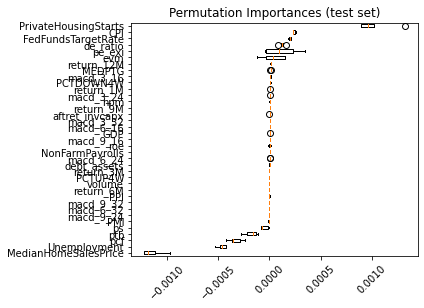

Permutation importance > 0:
['debt_assets', 'de_ratio', 'evm', 'pe_exi', 'roe', 'npm', 'aftret_invcapx', 'CPI', 'FedFundsTargetRate', 'GDP', 'PrivateHousingStarts', 'NonFarmPayrolls', 'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M', 'macd_3_16', 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24', 'macd_9_16']


<Figure size 432x288 with 0 Axes>

In [200]:
#permutation importance
clf_importance,clf_features_pi = feature_importance(clf_all, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)
plt.savefig("Figures/TL_TestCLF_PI.png")

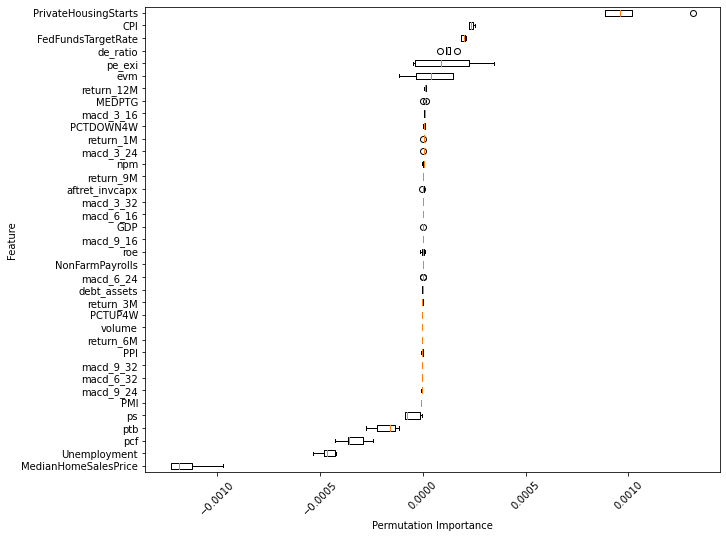

In [201]:
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
result = clf_importance
sorted_idx = result.importances_mean.argsort()
labels = np.array(features)
plt.figure(figsize = (10,7))
plt.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx]
)
#plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.xticks(rotation = 45)
plt.xlabel("Permutation Importance", fontsize = 10)
plt.ylabel("Feature", fontsize = 10)
#plt.show()
plt.savefig("Figures/TL_TestCLF_PI.png",bbox_inches = "tight",dpi = 1000)

In [202]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

clf_all.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDclf_37features_8layers_3epochs.h5


In [203]:
#load model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

loaded_model = tf.keras.models.load_model(label, compile = False)

## 2b) Returns-only features

Training Set: 29259, Test Set: 46829



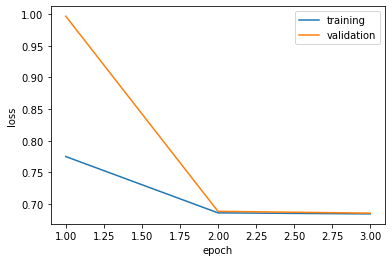

In [204]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
clf_ret = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_ret.summary())
clf_ret, history = train_NN(clf_ret, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

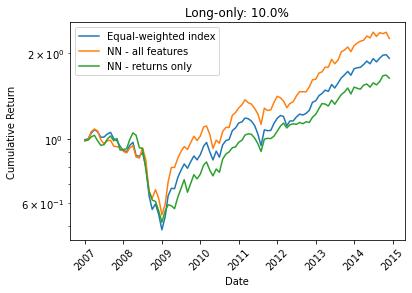

In [205]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_ret, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_ret, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")
plt.title("Long-only: " + str(pct*100) + "%");

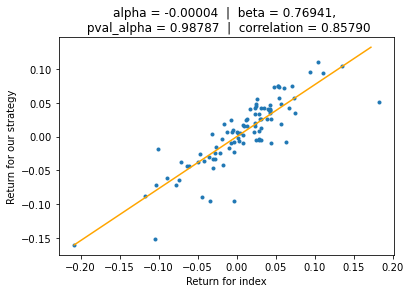

In [206]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [207]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

mar_retonly = calc_mar(rets_retonly)
sharpe_retonly = calc_sharpe(rets_retonly)
sortino_retonly = calc_sortino(rets_retonly)
mdd_retonly = calc_mdd(rets_retonly)
print("NN mar, returns only: ", mar_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("NN sortino, returns only: ", sortino_retonly)
print("NN mdd, returns only: ", mdd_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.6407786772237193
NN mar, returns only:  0.07932417320368668
NN sharpe, returns only:  0.45702940231435285
NN sortino, returns only:  0.5894793033597261
NN mdd, returns only:  (0.5106430514019983, 24)
Base index sharpe:  0.5417878573061478


In [208]:
#permutation importance
#importance = feature_importance(clf_ret, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [209]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

clf_ret.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDclf_14features_8layers_3epochs.h5


## 2c) Permutation Importance Features
- Only those with PI above 0
- and return features!

['debt_assets', 'de_ratio', 'evm', 'pe_exi', 'roe', 'npm', 'aftret_invcapx', 'CPI', 'FedFundsTargetRate', 'GDP', 'return_1M', 'return_9M']
Training Set: 29259, Test Set: 46829



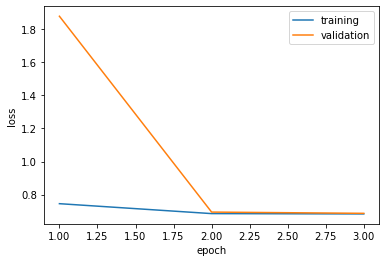

In [210]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
#features = ListUnion(features_pi,['return_1M', 'return_9M', 'return_12M'])
#labels = np.array(features)
#clf_features_pi = list(labels[clf_importance.importances_mean > 0])   #refilter
#features = clf_features_pi
features =['debt_assets', 'de_ratio', 'evm', 'pe_exi', 'roe', 'npm', 'aftret_invcapx','CPI', 'FedFundsTargetRate', 'GDP', 'return_1M', 'return_9M']
print(features)
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
clf_pi = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_pi.summary())
clf_pi, history = train_NN(clf_pi, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

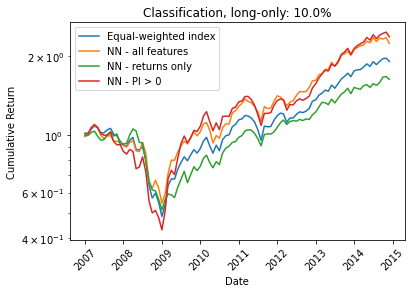

In [211]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_pi, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_pi, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);
plt.savefig("Figures/TL_TestCLF_Cumrets.png")

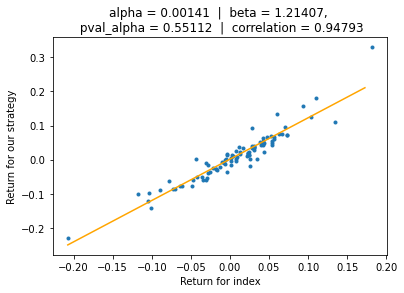

In [212]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [213]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

mar_pi = calc_mar(rets_pi)
sharpe_pi = calc_sharpe(rets_pi)
sortino_pi = calc_sortino(rets_pi)
mdd_pi = calc_mdd(rets_pi)
print("NN mar, PI > 0: ", mar_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("NN sortino, PI > 0: ", sortino_pi)
print("NN mdd, PI > 0: ", mdd_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.6407786772237193
NN sharpe, returns only:  0.45702940231435285
NN mar, PI > 0:  0.14742740189234116
NN sharpe, PI > 0:  0.5962920788428853
NN sortino, PI > 0:  0.9083742535257401
NN mdd, PI > 0:  (0.6055631724346879, 24)
Base index sharpe:  0.5417878573061478


In [214]:
#permutation importance
#importance = feature_importance(clf_pi, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [215]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

clf_pi.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDclf_12features_8layers_3epochs.h5


# 3) MLP regression

In [54]:
#model params
hidden = [300,300,50]
#dropout = [0.5,0.5,0.3,0.3,0.1]
#hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.25
is_regression = True
learning_rate = 0.001
num_epochs = 10

## 3a) All features

Training Set: 29259, Test Set: 46829, Validation Set: 41243 



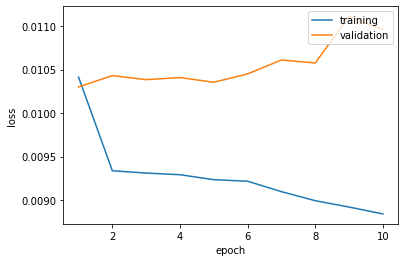

In [55]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
reg_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_all.summary())
reg_all, history = train_NN(reg_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

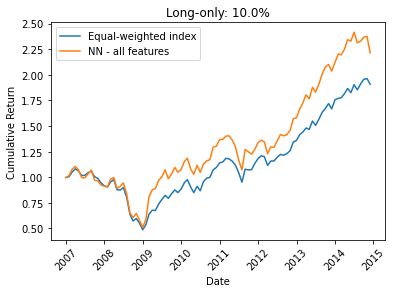

In [56]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
#pct = 0.2
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
#plt.yscale("log")
plt.title("Long-only: " + str(pct*100) + "%");

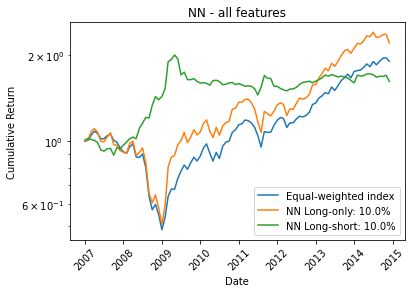

In [57]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
#pct = 0.2
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

returns_matrix_short, weight_matrix_short, rank_table_short, model_output_short = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = True, company_name = df_train.columns[0])
rets_short, cumrets_short = calc_returns(returns_matrix_short, weight_matrix = weight_matrix_short, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN Long-only: " + str(pct*100) + "%")
plt.plot(cumrets_short.index, cumrets_short, label = "NN Long-short: " + str(pct*100) + "%")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")
plt.title("NN - all features");
plt.savefig("Figures/TL_TestREG_Short.png")

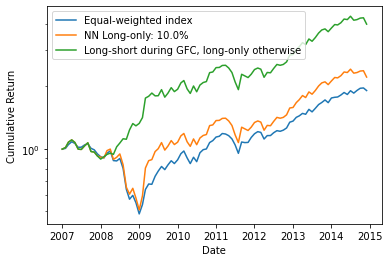

In [64]:
#combined
s1 = cumrets["2007-01-01":"2007-12-01"]
s2 = cumrets_short["2008-01-01":"2009-06-01"]
s3 = cumrets["2009-07-01":"2014-12-01"]
s2 = s2 * s1[-1]
s3 = s3 * s2[-1]
s_combined = pd.concat([s1, s2,s3], axis = 0)
plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN Long-only: " + str(pct*100) + "%")
plt.plot(s_combined.index, s_combined, label = "Long-short during GFC, long-only otherwise")
plt.legend();
plt.xlabel("Date");
#plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yticks([1,2, 3, 4])
plt.yscale("log")
plt.savefig("Figures/TL_TestREG_Switch.png")

In [59]:
r1 = rets["2007-01-01":"2007-12-01"]
r2 = rets_short["2008-01-01":"2009-06-01"]
r3 = rets["2009-07-01":"2014-12-01"]
r_combined = pd.concat([r1, r2,r3], axis = 0)
print("NN Switching mar: ", calc_mar(r_combined))
print("NN Switching sharpe: ", calc_sharpe(r_combined))
print("NN Switching sortino: ", calc_sortino(r_combined))
print("NN Switching mdd: ", calc_mdd(r_combined))


NN Switching mar:  0.22256257182474148
NN Switching sharpe:  1.1888970270262547
NN Switching sortino:  2.11424536407103
NN Switching mdd:  (0.2366938912812414, 55)


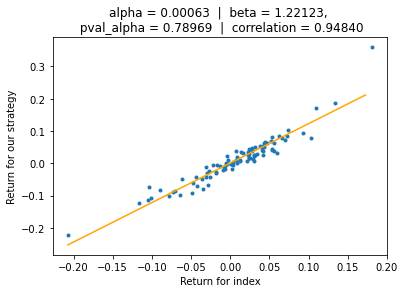

In [220]:
regression_analysis(np.array(rets_equal),np.array(rets))
plt.savefig("Figures/TL_TestREG_Alpha.png")

In [221]:
#sharpe ratio
mar = calc_mar(rets)
print("NN mar: ", mar)
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)
sortino = calc_sortino(rets)
print("NN sortino: ", sortino)
mdd = calc_mdd(rets)
print("NN mdd: ", mdd[0])
print()

mar_short = calc_mar(rets_short)
print("NN mar (ls): ", mar_short)
sharpe_short = calc_sharpe(rets_short)
print("NN sharpe (ls): ", sharpe_short)
sortino_short = calc_sortino(rets_short)
print("NN sortino (ls): ", sortino_short)
mdd_short = calc_mdd(rets_short)
print("NN mdd (ls): ", mdd_short[0])
print()

mar_equal = calc_mar(rets_equal)
print("Base index mar: ", mar_equal)
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
sortino_equal = calc_sortino(rets_equal)
print("Base Index sortino: ", sortino_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

NN mar:  0.13725187590893229
NN sharpe:  0.5529669588806189
NN sortino:  0.8492386108361986
NN mdd:  0.5400286069130138

NN mar (ls):  0.07234396034268542
NN sharpe (ls):  0.5047665180428059
NN sortino (ls):  0.9357732561989887
NN mdd (ls):  0.2768827186436976

Base index mar:  0.10436957412594827
Base index sharpe:  0.5414557888219247
Base Index sortino:  0.7005806428109661
Base index mdd:  0.5503912364267766


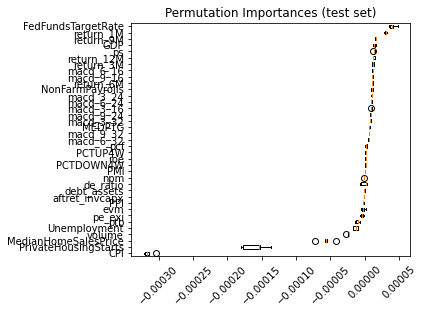

Permutation importance > 0:
['roe', 'ps', 'pcf', 'PMI', 'FedFundsTargetRate', 'GDP', 'NonFarmPayrolls', 'MEDPTG', 'PCTUP4W', 'PCTDOWN4W', 'return_1M', 'return_3M', 'return_6M', 'return_9M', 'return_12M', 'macd_3_16', 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24', 'macd_6_32', 'macd_9_16', 'macd_9_24', 'macd_9_32']


In [222]:
#permutation importance
reg_importance,reg_features_pi = feature_importance(reg_all, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

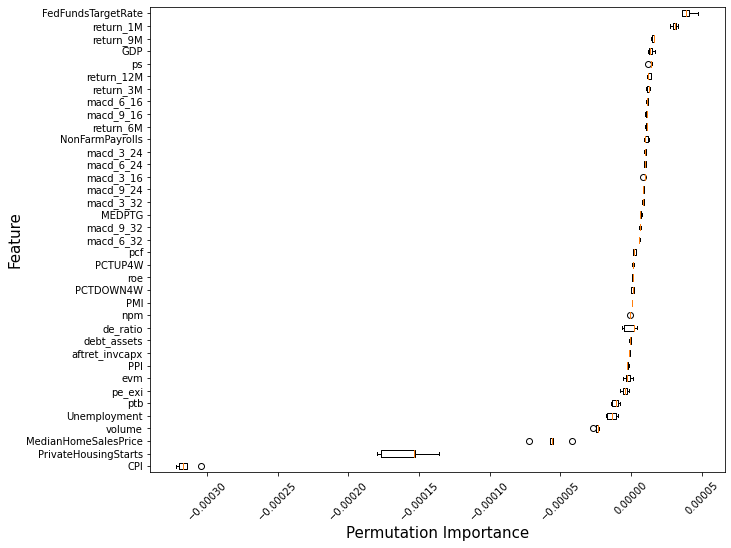

In [223]:
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
result = reg_importance
sorted_idx = result.importances_mean.argsort()
labels = np.array(features)
plt.figure(figsize = (10,7))
plt.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx]
)
#plt.title("Permutation Importances (test set)")

plt.tight_layout()
plt.xticks(rotation = 45)
plt.xlabel("Permutation Importance", fontsize = 15)
plt.ylabel("Feature", fontsize = 15)
#plt.show()
plt.savefig("Figures/TL_TestREG_PI.png",bbox_inches = "tight",dpi = 1000)

In [224]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

reg_all.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDreg_37features_3layers_10epochs.h5


## 3b) Returns-only features

Training Set: 29259, Test Set: 46829



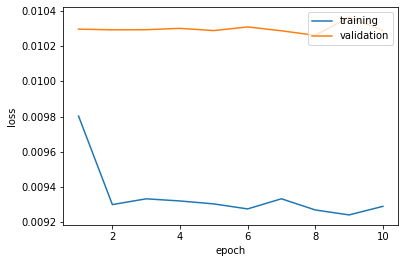

In [225]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
reg_ret = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_ret.summary())
reg_ret, history = train_NN(reg_ret, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

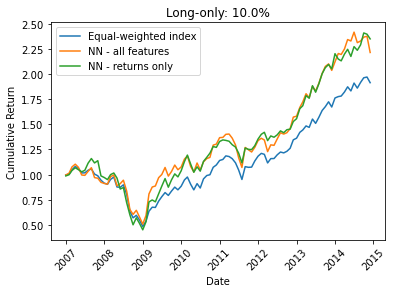

In [226]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_ret, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_ret, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.title("Long-only: " + str(pct*100) + "%");

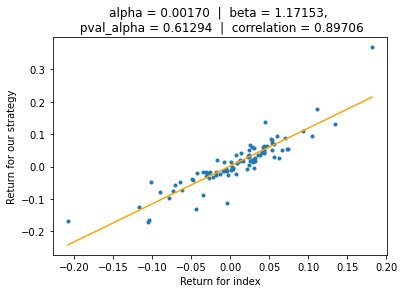

In [227]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [228]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

mar_retonly = calc_mar(rets_retonly)
sharpe_retonly = calc_sharpe(rets_retonly)
sortino_retonly = calc_sortino(rets_retonly)
mdd_retonly = calc_mdd(rets_retonly)
print("NN mar, returns only: ", mar_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("NN sortino, returns only: ", sortino_retonly)
print("NN mdd, returns only: ", mdd_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.5529669588806189
NN mar, returns only:  0.14689778493327932
NN sharpe, returns only:  0.5813355808783355
NN sortino, returns only:  0.87423741934859
NN mdd, returns only:  (0.6105771802253688, 24)
Base index sharpe:  0.5414557888219247


In [229]:
#permutation importance
#importance = feature_importance(reg_ret, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [230]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

reg_ret.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDreg_14features_3layers_10epochs.h5


## 3c) Permutation Importance Features
- Only those with PI above 0
- and return features!

['roe', 'ps', 'pcf', 'PMI', 'FedFundsTargetRate', 'GDP', 'NonFarmPayrolls', 'MEDPTG', 'PCTUP4W', 'PCTDOWN4W', 'return_1M', 'return_3M']
Training Set: 29259, Test Set: 46829



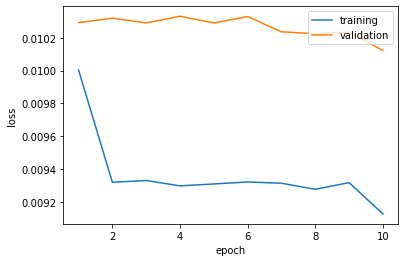

In [231]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data

features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
#labels = np.array(features)
#reg_features_pi = list(labels[reg_importance.importances_mean > -0.00000])   #refilter
#features = reg_features_pi
#features = ['roe', 'ps', 'pcf', 'PMI', 'FedFundsTargetRate', 'GDP', 'NonFarmPayrolls', 'MEDPTG', 'PCTUP4W', 'PCTDOWN4W', 
#            'return_1M', 'return_3M', 'return_6M', 'return_9M', 'return_12M', 'macd_3_16', 
# 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24', 'macd_6_32', 'macd_9_16', 'macd_9_24', 'macd_9_32']
features = ['roe', 'ps', 'pcf', 'PMI', 'FedFundsTargetRate', 'GDP','NonFarmPayrolls', 'MEDPTG', 'PCTUP4W', 'PCTDOWN4W', 
            'return_1M', 'return_3M']
print(features)
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
reg_pi = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_pi.summary())
reg_pi, history = train_NN(reg_pi, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

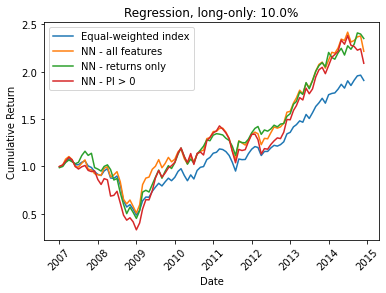

In [232]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_pi, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_pi, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);
plt.savefig("Figures/TL_TestREG_Cumrets.png")

In [233]:
cumrets_equal.to_pickle("cumrets_equal.pkl")
rets_equal.to_pickle("rets_equal.pkl")

In [234]:
#save rankings
model_output = reg_pi.predict(x_test)
if is_regression == False or is_regression == "brier":
    model_output = model_output[:,1]
#map to original test dataframe for price data
predictions = df_test.iloc[:,:5]
predictions["pred"] = model_output

#rank predictions
predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
pred_table = pd.pivot_table(predictions, values="pred", index=["month"],
                columns=[df_test.columns[0]])
rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                columns=[df_test.columns[0]])

rank_table.to_csv("Rankings/NNwithMACD_Regression_ranks.csv")
pred_table.to_csv("Rankings/NNwithMACD_Regression_modeloutputs.csv")

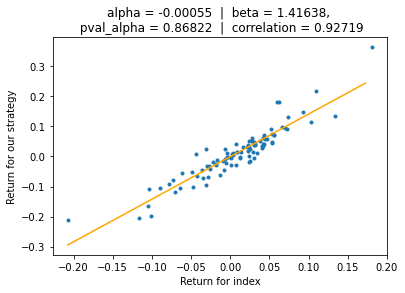

In [235]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [236]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

mar_pi = calc_mar(rets_pi)
sharpe_pi = calc_sharpe(rets_pi)
sortino_pi = calc_sortino(rets_pi)
mdd_pi = calc_mdd(rets_pi)
print("NN mar, PI > 0: ", mar_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("NN sortino, PI > 0: ", sortino_pi)
print("NN mdd, PI > 0: ", mdd_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.5529669588806189
NN sharpe, returns only:  0.5813355808783355
NN mar, PI > 0:  0.14319614602257147
NN sharpe, PI > 0:  0.4863123708036245
NN sortino, PI > 0:  0.7231753713674229
NN mdd, PI > 0:  (0.6976942335981542, 24)
Base index sharpe:  0.5414557888219247


In [237]:
#permutation importance
#importance = feature_importance(reg_pi, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [238]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

reg_pi.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDreg_12features_3layers_10epochs.h5


# 4) Tune models & validate

## 4a) Hyperparameter tuning sklearn

In [ ]:
tic = time()
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

search_model = KerasClassifier(build_fn = create_NN)
param_grid = dict(epochs = [5,10,25], 
                  hidden = [[300,300,300, 200, 200, 100, 100, 50],
                            [300,300, 50]],
                  dropout = [0.1,0.25,0.5],
                  learning_rate = [1, 0.1,0.01, 0.01, 0.001,0.0001],
                  is_search = [True], is_regression = [False], input_dim = [len(features)])
search = GridSearchCV(estimator = search_model, param_grid = param_grid, cv = 3)
search = search.fit(x_train, y_train)

best_params=search.best_params_
accuracy=search.best_score_

toc = time()
print(toc-tic, "secs")


In [248]:
print("params:",search.best_params_)
print("metric:",search.best_score_)

params: {'dropout': 0.1, 'epochs': 5, 'hidden': [300, 300, 300, 200, 200, 100, 100, 50], 'input_dim': 37, 'is_regression': False, 'is_search': True, 'learning_rate': 1}
metric: nan


In [ ]:
tic = time()
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

search_model = KerasClassifier(build_fn = create_NN)
param_grid = dict(epochs = [5,10,25], 
                  hidden = [[300,300,300, 200, 200, 100, 100, 50],
                            [300,300, 50]],
                  dropout = [0.1,0.25,0.5],
                  learning_rate = [1, 0.1,0.01, 0.01, 0.001,0.0001],
                  is_search = [True], is_regression = [True], input_dim = [len(features)])
search = GridSearchCV(estimator = search_model, param_grid = param_grid, cv = 3)
search = search.fit(x_train, y_train)

best_params=search.best_params_
accuracy=search.best_score_

toc = time()
print(toc-tic, "secs")


In [ ]:
print("params:",search.best_params_)
print("metric:",search.best_score_)

In [270]:
#fast test

features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

search_model = KerasClassifier(build_fn = create_NN)
param_grid = dict(epochs = [5,10], 
                  hidden = [[200, 100, 100, 50],
                            [100, 50]],
                  dropout = [0, 0.1],
                  learning_rate = [0.1,0.01],
                  is_search = [True], is_regression = [False],input_dim = [len(features)])
search = GridSearchCV(estimator = search_model, param_grid = param_grid, cv = 3, scoring = "accuracy")
search = search.fit(x_train, y_train, verbose = 1)

best_params=search.best_params_
accuracy=search.best_score_



Training Set: 76088, Test Set: 41243

Epoch 1/5


C:\Users\pyliu\AppData\Local\Temp/ipykernel_70928/3204865257.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  search_model = KerasClassifier(build_fn = create_NN)


1586/1586 [==============================] - 5s 2ms/step - loss: 0.6993 - accuracy: 0.5392
Epoch 2/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6988 - accuracy: 0.5462
Epoch 3/5
1586/1586 [==============================] - 4s 2ms/step - loss: 0.6960 - accuracy: 0.5467
Epoch 4/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6954 - accuracy: 0.5502
Epoch 5/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6953 - accuracy: 0.5471
Epoch 1/5


C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 205, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise 

1586/1586 [==============================] - 4s 2ms/step - loss: 0.6995 - accuracy: 0.5492
Epoch 2/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.7003 - accuracy: 0.5510
Epoch 3/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6977 - accuracy: 0.5506
Epoch 4/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6981 - accuracy: 0.5537
Epoch 5/5
1586/1586 [==============================] - 4s 2ms/step - loss: 0.6957 - accuracy: 0.5568
Epoch 1/5


C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 205, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise 

1586/1586 [==============================] - 4s 2ms/step - loss: 0.7010 - accuracy: 0.5454
Epoch 2/5
1586/1586 [==============================] - 4s 3ms/step - loss: 0.7041 - accuracy: 0.5452
Epoch 3/5
1586/1586 [==============================] - 4s 2ms/step - loss: 0.6998 - accuracy: 0.5481
Epoch 4/5
1586/1586 [==============================] - 4s 2ms/step - loss: 0.6952 - accuracy: 0.5553
Epoch 5/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6933 - accuracy: 0.5579
Epoch 1/5


C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 205, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise 

1586/1586 [==============================] - 4s 2ms/step - loss: 0.6810 - accuracy: 0.5658
Epoch 2/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6745 - accuracy: 0.5819
Epoch 3/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6705 - accuracy: 0.5857
Epoch 4/5
1586/1586 [==============================] - 3s 2ms/step - loss: 0.6674 - accuracy: 0.5879
Epoch 5/5
1586/1586 [==============================] - 4s 2ms/step - loss: 0.6647 - accuracy: 0.5954
Epoch 1/5


C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 205, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\pyliu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise 

1586/1586 [==============================] - 4s 2ms/step - loss: 0.6798 - accuracy: 0.5663
Epoch 2/5
1586/1586 [==============================] - 4s 3ms/step - loss: 0.6738 - accuracy: 0.5805
Epoch 3/5
1586/1586 [==============================] - 4s 2ms/step - loss: 0.6704 - accuracy: 0.5842
Epoch 4/5
 754/1586 [=============>................] - ETA: 1s - loss: 0.6677 - accuracy: 0.5923

KeyboardInterrupt: 

In [267]:
sorted(skl.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [ ]:
print("params:",search.best_params_)
print("metric:",search.best_score_)

In [101]:
print("params:",search.best_params_)
print("metric:",search.best_score_)

params: {'dropout': 0.1, 'epochs': 10, 'hidden': [100, 50], 'input_dim': 28, 'is_regression': False, 'is_search': True, 'learning_rate': 0.01}
metric: 0.5588316520055135


## 4b) Best Test Models

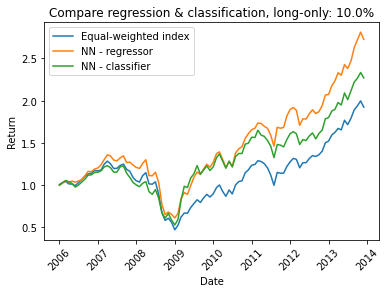

In [174]:
#calculate cost-adjusted returns & plot
is_short = False
k = 5
#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

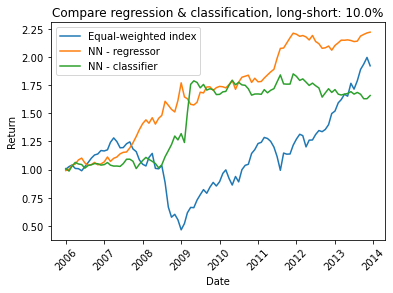

In [175]:
#calculate cost-adjusted returns & plot
is_short = True
k = 5
#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

## 4c) Validation

In [92]:
df_train = df_nn[(df_nn["month"]>= "2007-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


Training Set: 46829, Test Set: 41243, Validation Set: 41243 



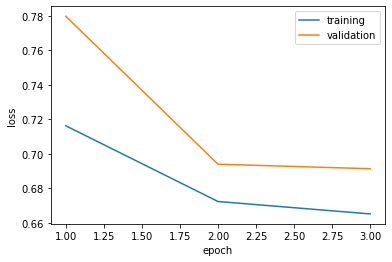

In [93]:
#model params
#hidden = [300,300,50]
#dropout = 0.3
hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.1
is_regression = False
learning_rate = 0.1
num_epochs = 3

#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
            'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
clf_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_all.summary())
clf_all, history = train_NN(clf_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

Training Set: 46829, Test Set: 41243, Validation Set: 41243 



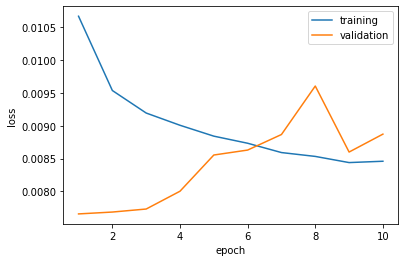

In [94]:
#model params
hidden = [300,300,50]
#dropout = [0.5,0.5,0.3,0.3,0.1]
#hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.25
is_regression = True
learning_rate = 0.001
num_epochs = 10

#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
reg_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_all.summary())
reg_all, history = train_NN(reg_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

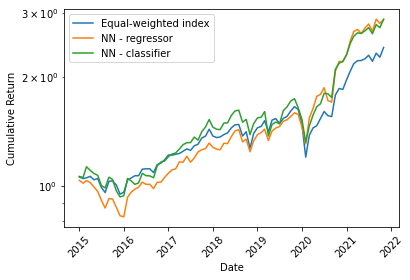

In [95]:
#validation
#calculate cost-adjusted returns & plot
is_short = False
pct = 0.1
k = 5

#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

rets_equal.to_pickle("rets_EQUALvalid.pkl")
cumrets_equal.to_pickle("cumrets_EQUALvalid.pkl")
rets_reg.to_pickle("RetSeries/rets_NNreg_valid.pkl")
cumrets_reg.to_pickle("RetSeries/cumrets_NNreg_valid.pkl")
rets_clf.to_pickle("RetSeries/rets_NNclf_valid.pkl")
cumrets_clf.to_pickle("RetSeries/cumrets_NNclf_valid.pkl")

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.yscale("log")
plt.ylabel("Cumulative Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
#plt.title(title);
plt.savefig("Figures/TL_Validation_Cumrets.png")

In [68]:
print(calc_mar(rets_equal))
print(calc_mar(rets_clf))
print(calc_mar(rets_reg))

print()

print(calc_sharpe(rets_equal))
print(calc_sharpe(rets_clf))
print(calc_sharpe(rets_reg))

print()

print(calc_sortino(rets_equal))
print(calc_sortino(rets_clf))
print(calc_sortino(rets_reg))

print()

print(calc_mdd(rets_equal))
print(calc_mdd(rets_clf))
print(calc_mdd(rets_reg))

0.15085864682089722
0.18354818446835797
0.18219232928359164

0.9110410369122878
1.0188743636267947
1.0237357287582807

1.0435383797657294
1.4237515943782357
1.8617675315956246

(0.2736139104787979, 61)
(0.24116736461922206, 61)
(0.2065226220466947, 12)


In [244]:
msp500_unique = pd.read_pickle("FinalMembers/linktable.pkl")
investments = weight_matrix_reg.sum(axis = 0).sort_values(ascending = False)
investments = pd.DataFrame(investments).merge(msp500_unique, left_index= True, right_on = "PERMNO", how = "left")
investments.rename(columns={0:"total_weight"}, inplace=True)
investments = investments.drop_duplicates(["PERMNO"])
investments

,total_weight,PERMNO,start,ending,NAMEDT,NAMEENDT,CUSIP,TICKER
741,0.651020,17750,1957-03-01,2021-12-31,1968-01-02,2001-08-23,49436810,KMB
4339,0.649796,86339,2012-03-14,2021-12-31,1998-08-18,2001-04-24,22822V10,TWRS
340,0.568163,12650,1999-04-05,2000-07-12,1968-01-02,2000-07-12,48517030,KSU
4254,0.567755,85913,1998-05-21,2021-12-31,1998-03-30,2002-01-01,57190320,MAR
8,0.547755,10107,1994-06-07,2021-12-31,1986-03-13,2004-06-09,59491810,MSFT
...,...,...,...,...,...,...,...,...
3069,0.000000,75577,2000-04-18,2015-12-28,1988-03-31,2004-06-09,02144110,ALTR
1136,0.000000,23501,2007-11-09,2016-03-29,1968-01-02,2002-01-01,71329110,POM
3035,0.000000,75224,2006-02-01,2017-03-15,1987-11-11,2002-01-01,41308610,HAR
3871,0.000000,82196,2009-04-02,2015-03-20,1999-04-26,2002-01-01,24791620,DNR


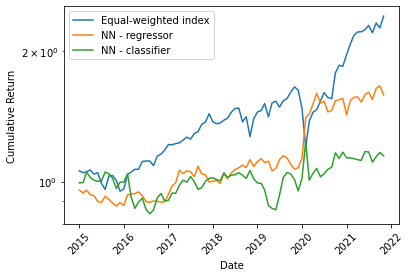

In [245]:
#validation
#calculate cost-adjusted returns & plot
is_short = True
pct = 0.1
k = 5
#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.yscale("log")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
#plt.title(title);
plt.savefig("Figures/TL_Validation_Short.png")

In [247]:
print(calc_mar(rets_equal))
print(calc_mar(rets_clf))
print(calc_mar(rets_reg))

print()

print(calc_sharpe(rets_equal))
print(calc_sharpe(rets_clf))
print(calc_sharpe(rets_reg))

print()

print(calc_sortino(rets_equal))
print(calc_sortino(rets_clf))
print(calc_sortino(rets_reg))

print()

print(calc_mdd(rets_equal))
print(calc_mdd(rets_clf))
print(calc_mdd(rets_reg))

0.15085864682089722
0.03425426792849828
0.0791607270783814

0.9110410369122878
0.2033040966616808
0.546490767683794

1.0435383797657294
0.2892984457294253
1.2657534284589118

(0.2736139104787979, 61)
(0.19875319040731876, 19)
(0.10843175606235667, 72)


# 5) Pairwise LTR - RankNet
- queries = dates
- documents = valid tickers, the features of which are xi
- scores = future 1M returns, si

Target probabilities:

- Pij = 1 if si > sj, 0.5 if si = sj, 0 if si < sj

Predicted probabilities
- Oij = f(xi) - f(xj)
- Squeeze through logistic function
- Qij = 1-Qji = exp(Oij) / (1 + exp(Oij)

Use cross-entropy loss.

In [61]:
#model params
#hidden = [300,300,150,150,50]
#dropout = [0.5,0.5,0.3,0.3,0.1]
#hidden = [300,300,300, 200, 200, 100, 100, 50]
#dropout = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
hidden = [300,300, 50]
hidden = [300]
dropout = [0.1,0.1,0.1]
is_regression = True
is_ltr = True
learning_rate = 0.001
num_epochs = 10
seed = 1

## 5a) Build model

In [62]:
# model architecture
class RankNet(Model):
    def __init__(self, hidden_layers, dropout_layers, stddev = 0.01, seed = 1):
        super().__init__()
        #input + hidden layers
        self.dense = [layers.Dense(hidden_layers[i], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=stddev, seed = seed)) for i in range(len(hidden_layers))]
        self.dropout = [Dropout(dropout_layers[i], seed = seed) for i in range(len(dropout_layers))]
        #output layer
        self.o = layers.Dense(1, activation='linear')
        #subtract outputs
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        #input layer
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        #hidden layers
        for dense, dropout in zip(self.dense[1:],self.dropout[1:]):
            densei = dense(densei)
            densej = dense(densej)
            #dropout
            densei = dropout(densei)
            densej = dropout(densej)
        #output layer
        oi = self.o(densei)
        oj= self.o(densej)
        #subtraction layer
        oij = self.oi_minus_oj([oi, oj])
        #apply sigmoid to output
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(5)), Input(shape=(5))]
        return Model(inputs=x, outputs=self.call(x))


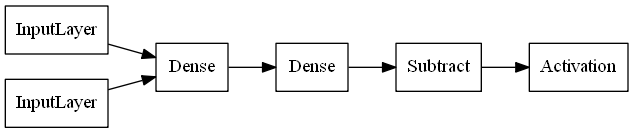

In [63]:
# visualize model architecture
plot_model(RankNet(hidden,dropout, stddev = 0.01, seed = seed).build_graph(), show_shapes=False,rankdir='LR',show_layer_names=False)

## 5b) Process data
- We need to create pairs of inputs 
  - 2 each of x_train, x_test; 
  - 1 each of y_train, y_test; 
  - 1 each of pair_id_train, pair_id_test to match pairs of inputs
  
- need more efficient method for creating the pairs.
    - separate validation set by query id
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df, groups=df['id'])
    https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

- need to edit this so pair_query_id contains the stock identifier

In [252]:
df_train = df_nn[(df_nn["month"]>= "2002-01") & (df_nn["month"]<= "2006-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2007-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_validate = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


In [254]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)


#split data
"""
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
"""
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train,q_train,x_test,y_test,q_test,x_validate,y_validate,q_validate= get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression, is_ltr = is_ltr)


Training Set: 29259, Test Set: 46829, Validation Set: 41243 



In [131]:
#format train set

tic = time()
xi_train, xj_train, pij_train, pair_train, query_train = create_pairs(
                query = q_train, doc_features = x_train, doc_scores = y_train)
toc = time()
print("training set:", toc - tic, "secs")
print(np.shape(xi_train))

np.save("PairwiseLTRwithMACD/xi_train.npy",xi_train)
np.save("PairwiseLTRwithMACD/xj_train.npy",xj_train)
np.save("PairwiseLTRwithMACD/pij_train.npy",pij_train)
np.save("PairwiseLTRwithMACD/pair_train.npy",pair_train)
np.save("PairwiseLTRwithMACD/query_train.npy",query_train)
print("done")


training set: 17.442418575286865 secs
(7119599, 37)
done


In [132]:
#format test set

tic = time()   
xi_test, xj_test, pij_test, pair_test, query_test = create_pairs(
                query = q_test, doc_features = x_test, doc_scores = y_test)
toc = time()
print("training set:", toc - tic, "secs")
print(np.shape(xi_test))

np.save("PairwiseLTRwithMACD/xi_test.npy",xi_test)
np.save("PairwiseLTRwithMACD/xj_test.npy",xj_test)
np.save("PairwiseLTRwithMACD/pij_test.npy",pij_test)
np.save("PairwiseLTRwithMACD/pair_test.npy",pair_test)
np.save("PairwiseLTRwithMACD/query_test.npy",query_test)
print("done")


training set: 31.614877700805664 secs
(11398663, 37)
done


In [133]:
#format validation set

tic = time()   
xi_validate, xj_validate, pij_validate, pair_validate, query_validate = create_pairs(
                query = q_validate, doc_features = x_validate, doc_scores = y_validate)
toc = time()
print("validation set:", toc - tic, "secs")
print(np.shape(xi_validate))

np.save("PairwiseLTRwithMACD/xi_validate.npy",xi_validate)
np.save("PairwiseLTRwithMACD/xj_validate.npy",xj_validate)
np.save("PairwiseLTRwithMACD/pij_validate.npy",pij_validate)
np.save("PairwiseLTRwithMACD/pair_validate.npy",pair_validate)
np.save("PairwiseLTRwithMACD/query_validate.npy",query_validate)
print("done")


validation set: 31.38857078552246 secs
(10226628, 37)
done


In [255]:
#load training set
xi_train= np.load("PairwiseLTRwithMACD/xi_train.npy")
xj_train= np.load("PairwiseLTRwithMACD/xj_train.npy")
pij_train = np.load("PairwiseLTRwithMACD/pij_train.npy")
pair_train = np.load("PairwiseLTRwithMACD/pair_train.npy")
query_train = np.load("PairwiseLTRwithMACD/query_train.npy", allow_pickle = True)

#load test set
xi_test= np.load("PairwiseLTRwithMACD/xi_test.npy")
xj_test= np.load("PairwiseLTRwithMACD/xj_test.npy")
pij_test = np.load("PairwiseLTRwithMACD/pij_test.npy")
pair_test = np.load("PairwiseLTRwithMACD/pair_test.npy")
query_test = np.load("PairwiseLTRwithMACD/query_test.npy", allow_pickle = True)

#load validation set
xi_validate= np.load("PairwiseLTRwithMACD/xi_validate.npy")
xj_validate= np.load("PairwiseLTRwithMACD/xj_validate.npy")
pij_validate = np.load("PairwiseLTRwithMACD/pij_validate.npy")
pair_validate = np.load("PairwiseLTRwithMACD/pair_validate.npy")
query_validate = np.load("PairwiseLTRwithMACD/query_validate.npy", allow_pickle = True)

print("Train:", np.shape(xi_train),"Test:", np.shape(xi_test),"Validation:", np.shape(xi_validate))

print("done")

Train: (7119599, 37) Test: (11398663, 37) Validation: (10226628, 37)
done


## 5c) Train RankNet

In [257]:
# train model using compile and fit
#learning_rate = 1e-6
learning_rate = 0.1
hidden = [1000,1000]
dropout = [0.1,0.1]
ranknet = RankNet(hidden,dropout,stddev = 0.01,seed=seed)
opt = optimizers.Adam(learning_rate=learning_rate)
ranknet.compile(optimizer=opt, loss='binary_crossentropy')
#ranknet.compile(optimizer=opt, loss=custom_brier)
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=1, batch_size=2500, validation_data=([xi_test, xj_test], pij_test))

2848/2848 [==============================] - 620s 217ms/step - loss: 5.5212 - val_loss: 0.6949


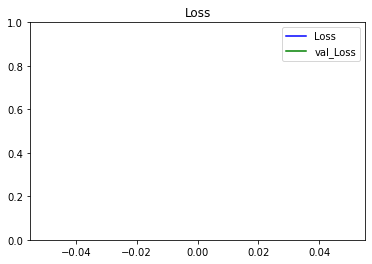

In [258]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [259]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "FinalModels/PairwiseLTRwithMACD.tf"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: FinalModels/PairwiseLTRwithMACD.tf\assets
Model saved to: FinalModels/PairwiseLTRwithMACD.tf


## 5d) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [260]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_test)
print(n_outputs)
model_output = ranknet.predict([xi_test[:n_outputs], xj_test[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

11398663
make predictions: 850.099422454834 secs


In [275]:
rank_table

PERMNO,10078.0,10104.0,10107.0,10137.0,10138.0,10145.0,10147.0,10225.0,10299.0,10324.0,...,92618.0,92655.0,92709.0,92778.0,92890.0,92988.0,93002.0,93096.0,93159.0,93422.0
month,,,,,,,,,,,,,,,,,,,,,
2007-01,479.0,384.0,380.0,162.0,370.0,253.0,311.0,346.0,368.0,391.0,...,NaN,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02,482.0,389.0,377.0,181.0,350.0,204.0,305.0,248.0,328.0,395.0,...,NaN,182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03,449.0,384.0,383.0,187.0,393.0,204.0,300.0,233.0,375.0,377.0,...,NaN,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04,485.0,370.0,367.0,206.0,362.0,272.0,320.0,254.0,225.0,381.0,...,NaN,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05,480.0,385.0,329.0,168.0,316.0,211.0,374.0,310.0,307.0,376.0,...,NaN,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08,NaN,305.0,288.0,NaN,397.0,359.0,123.0,NaN,452.0,NaN,...,263.0,242.0,192.0,222.0,398.0,295.0,344.0,331.0,214.0,9.0
2014-09,NaN,275.0,298.0,NaN,431.0,377.0,127.0,NaN,411.0,NaN,...,280.0,278.0,198.0,230.0,322.0,286.0,347.0,373.0,241.0,6.0
2014-10,NaN,246.0,271.0,NaN,415.0,404.0,135.0,NaN,382.0,NaN,...,287.0,263.0,204.0,303.0,323.0,381.0,283.0,376.0,273.0,19.0


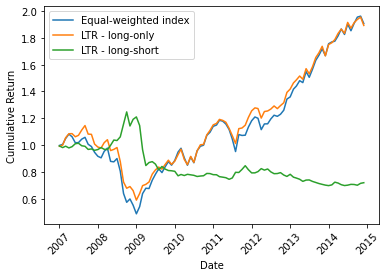

In [261]:
#calc returns
k = 5
pct = 0.1
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_test,  query_test, pair_test,company_name = "PERMNO", pct = pct, is_short = False, max_ret = 10, discretise = False)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_test,  query_test, pair_test,company_name = "PERMNO", pct = pct, is_short = True, max_ret = 10, discretise = False)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

cumrets_equal = pd.read_pickle("cumrets_equal.pkl")
rets_equal = pd.read_pickle("rets_equal.pkl")
plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - long-only")
plt.plot(cumrets2.index, cumrets2, label = "LTR - long-short")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
#plt.title("Long-only: " + str(pct*100) + "%");
#plt.savefig("Figures/TL_TestLTR_Cumrets.png")

In [262]:
cumrets1.to_pickle("cumrets_LTRtest.pkl")
rets1.to_pickle("rets_LTRtest.pkl")
cumrets2.to_pickle("cumrets_LTRtest_short.pkl")
rets2.to_pickle("rets_LTRtest_short.pkl")

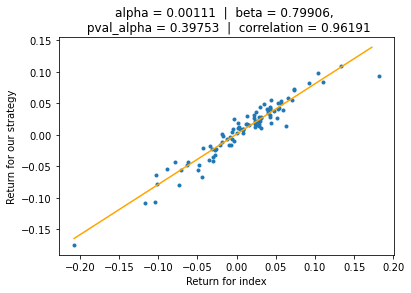

In [263]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [264]:
#sharpe ratio
mar = calc_mar(rets1)
print("LTR probabilistic mar: ", mar)
sharpe = calc_sharpe(rets1)
print("LTR probabilistic sharpe: ", sharpe)
sortino = calc_sortino(rets1)
print("LTR probabilistic sortino: ", sortino)
mdd = calc_mdd(rets1)
print("LTR probabilistic mdd: ", mdd[0])

print()

mar = calc_mar(rets2)
print("LTR probabilistic mar (ls): ", mar)
sharpe = calc_sharpe(rets2)
print("LTR probabilistic sharpe (ls): ", sharpe)
sortino = calc_sortino(rets2)
print("LTR probabilistic sortino (ls): ", sortino)
mdd = calc_mdd(rets2)
print("LTR probabilistic mdd (ls): ", mdd[0])

print()
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR probabilistic mar:  0.09708234356751522
LTR probabilistic sharpe:  0.6063074037638636
LTR probabilistic sortino:  0.7578721816576092
LTR probabilistic mdd:  0.48627265306911494

LTR probabilistic mar (ls):  -0.03453307724068799
LTR probabilistic sharpe (ls):  -0.3148484897992528
LTR probabilistic sortino (ls):  -0.35627486720944845
LTR probabilistic mdd (ls):  0.44137589041950764

Base index sharpe:  0.5413739461084112
Base index mdd:  0.5503925391111795


## 5e) Validate RankNet

In [390]:
# train model using compile and fit
#learning_rate = 1e-6
learning_rate = 0.1
hidden = [1000,1000]
dropout = [0.1,0.1]
ranknet = RankNet(hidden,dropout,stddev = 0.01,seed=seed)
opt = optimizers.Adam(learning_rate=learning_rate)
ranknet.compile(optimizer=opt, loss='binary_crossentropy')
#ranknet.compile(optimizer=opt, loss=custom_brier)
history = ranknet.fit([xi_test, xj_test], pij_test, epochs=1, batch_size=2500, validation_data=([xi_validate, xj_validate], pij_validate))

4560/4560 [==============================] - 953s 209ms/step - loss: 5.5439 - val_loss: 0.7142


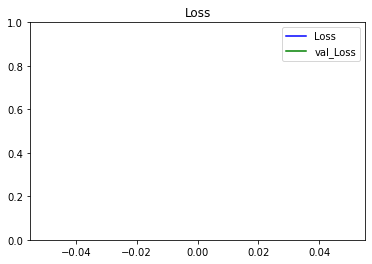

In [391]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [392]:
# save model
if is_regression == True:
    label = "FinalModels/Valid_NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "FinalModels/Valid_PairwiseLTRwithMACD.tf"
else:
    label = "FinalModels/Valid_NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: FinalModels/Valid_PairwiseLTRwithMACD.tf\assets
Model saved to: FinalModels/Valid_PairwiseLTRwithMACD.tf


## 5f) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [411]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_validate)
print(n_outputs)
model_output = ranknet.predict([xi_validate[:n_outputs], xj_validate[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

10226628
make predictions: 1164.9509632587433 secs


In [412]:
model_output

array([[0.5],
       [0.5],
       [0.5],
       ...,
       [0.5],
       [0.5],
       [0.5]], dtype=float32)

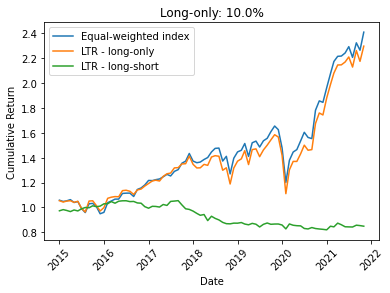

In [425]:
#calc returns
k = 5
pct = 0.1
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_validate,  query_validate, pair_validate,company_name = "PERMNO", pct = pct, is_short = False, max_ret = 10, discretise = False)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_validate,  query_validate, pair_validate,company_name = "PERMNO", pct = pct, is_short = True, max_ret = 10, discretise = False)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

cumrets_equal = pd.read_pickle("cumrets_EQUALvalid.pkl")
rets_equal = pd.read_pickle("rets_EQUALvalid.pkl")
plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - long-only")
plt.plot(cumrets2.index, cumrets2, label = "LTR - long-short")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.title("Long-only: " + str(pct*100) + "%");
plt.savefig("Figures/TL_ValidLTR_Cumrets.png")

In [418]:
cumrets1.to_pickle("cumrets_LTRvalid.pkl")
rets1.to_pickle("rets_LTRvalid.pkl")
cumrets2.to_pickle("cumrets_LTRvalid_short.pkl")
rets2.to_pickle("rets_LTRvalid_short.pkl")

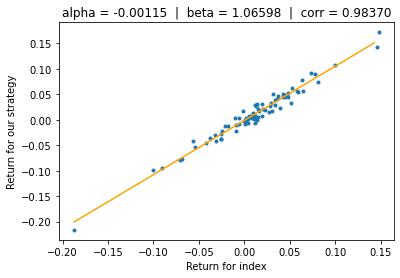

In [419]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [421]:
#sharpe ratio
mar = calc_mar(rets1)
print("LTR probabilistic mar: ", mar)
sharpe = calc_sharpe(rets1)
print("LTR probabilistic sharpe: ", sharpe)
sortino = calc_sortino(rets1)
print("LTR probabilistic sortino: ", sortino)
mdd = calc_mdd(rets1)
print("LTR probabilistic mdd: ", mdd[0])

print()

mar = calc_mar(rets2)
print("LTR probabilistic mar (ls): ", mar)
sharpe = calc_sharpe(rets2)
print("LTR probabilistic sharpe (ls): ", sharpe)
sortino = calc_sortino(rets2)
print("LTR probabilistic sortino (ls): ", sortino)
mdd = calc_mdd(rets2)
print("LTR probabilistic mdd (ls): ", mdd[0])

print()
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR probabilistic mar:  0.12751064430389492
LTR probabilistic sharpe:  0.7149257348810494
LTR probabilistic mdd:  0.29854056746597135
LTR probabilistic mar (ls):  -0.023222659746388263
LTR probabilistic sharpe (ls):  -0.39428627049792575
LTR probabilistic mdd (ls):  0.22166006810343586
Base index sharpe:  0.8222331145470622
Base index mdd:  0.2736139104787979


## 5e) Train RankNet with NDCG

In [71]:
# train model using compile and fit
learning_rate = 1e-3
ranknet = RankNet(hidden,dropout)
opt = optimizers.Adam(learning_rate=learning_rate)
#ranknet.compile(optimizer=opt, loss='binary_crossentropy',metrics=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"))
ranknet.compile(optimizer=opt, loss=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"),
    metrics=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"))

history = ranknet.fit([xi_train, xj_train], pij_train, epochs=3, batch_size=500, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/3


ValueError: in user code:

    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\losses.py", line 136, in __call__
        with backend.name_scope(self._name_scope), graph_ctx:
    File "C:\Users\pyliu\anaconda3\lib\contextlib.py", line 113, in __enter__
        return next(self.gen)

    ValueError: 'NDCG@5' is not a valid root scope name. A root scope name has to match the following pattern: ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$


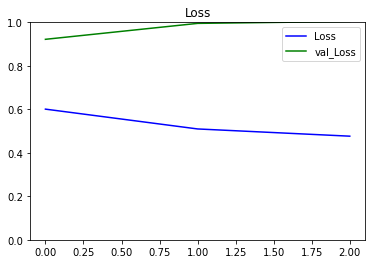

In [36]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [352]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "Models/PairwiseLTR_NDCG.tf"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: Models/PairwiseLTR.tf\assets
Model saved to: Models/PairwiseLTR.tf


## 5f) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [37]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_test)
print(n_outputs)
model_output = ranknet.predict([xi_test[:n_outputs], xj_test[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

11507828
make predictions: 384.26697611808777 secs


In [38]:
#calc returns
k = 3
pct = 0.1
is_short = False
discretise = False
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = True)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = False)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - discretise output")
plt.plot(cumrets2.index, cumrets2, label = "LTR - probabilistic output")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
plt.title("Long-only: " + str(pct*100) + "%");

KeyError: "['TICKER'] not in index"

In [ ]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [101]:
#sharpe ratio
mar = calc_mar(rets1)
print("LTR probabilistic mar: ", mar)
sharpe = calc_sharpe(rets1)
print("LTR probabilistic sharpe: ", sharpe)
mdd = calc_mdd(rets1)
print("LTR probabilistic mdd: ", mdd[0])

mar = calc_mar(rets2)
print("LTR probabilistic mar (ls): ", mar)
sharpe = calc_sharpe(rets2)
print("LTR probabilistic sharpe (ls): ", sharpe)
mdd = calc_mdd(rets2)
print("LTR probabilistic mdd (ls): ", mdd[0])

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR discretised sharpe:  0.17329528410918518
LTR discretised mdd:  0.8289862085002205
LTR probabilistic sharpe:  0.6343763419437249
LTR probabilistic mdd:  0.4891196628947123
Base index sharpe:  0.6120306030872815
Base index mdd:  0.5304379670749022


# 6) LTR with XGB

In [44]:
df_train = df_nn[(df_nn["month"]>= "2002-01") & (df_nn["month"]<= "2006-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2007-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_validate = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


In [45]:
ltr_pairwise = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=seed, 
    max_depth=10, 
    n_estimators=300, 
    )

ltr_listwise = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:map',
    random_state=seed,
    seed = seed,
    max_depth=10, 
    n_estimators=300, 
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1, 
    colsample_bynode = 1,
    nthread = 1,
    )


## 6a) Training

In [47]:
#model params defined in 1d
#reset seed
#split data
is_regression = True
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)
groups = df_train.groupby('month').size().to_frame('size')['size'].to_numpy()
groups

Training Set: 29259, Test Set: 46829, Validation Set: 41243 



array([482, 484, 484, 486, 486, 486, 485, 484, 485, 485, 485, 485, 485,
       485, 485, 486, 487, 487, 487, 488, 488, 489, 489, 489, 491, 491,
       491, 491, 490, 490, 490, 490, 490, 489, 490, 489, 489, 489, 488,
       488, 489, 490, 490, 490, 490, 489, 489, 486, 487, 488, 489, 489,
       489, 490, 489, 487, 485, 486, 485, 484], dtype=int64)

In [ ]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

ltr_listwise.fit(x_train, y_train,group=groups, verbose=True)
ltr_listwise.predict(x_test)

In [81]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

ltr_pairwise.fit(x_train, y_train,group=groups, verbose=True)
ltr_pairwise.predict(x_test)

array([-0.7428678 ,  0.7340806 , -0.20009024, ...,  1.9181614 ,
        3.4532847 ,  0.28404632], dtype=float32)

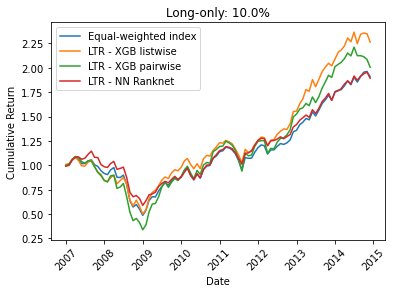

In [82]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
pct = 0.1
is_short = False
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(ltr_listwise, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

returns_matrix_pw, weight_matrix_pw, rank_table_pw, model_output_pw = get_Matrices(ltr_pairwise, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pw, cumrets_pw = calc_returns(returns_matrix_pw, weight_matrix = weight_matrix_pw, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(ltr_listwise, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

cumrets_rn = pd.read_pickle("cumrets_LTRtest.pkl")
rets_rn = pd.read_pickle("rets_LTRtest.pkl")
cumrets_equal = pd.read_pickle("cumrets_equal.pkl")
rets_equal = pd.read_pickle("rets_equal.pkl")

#rets.to_pickle("RetSeries/rets_XGBlistwise_test.pkl")
#cumrets.to_pickle("RetSeries/cumrets_XGBlistwise_test.pkl")
#rets_pw.to_pickle("RetSeries/rets_XGBpairwise_test.pkl")
#cumrets_pw.to_pickle("RetSeries/cumrets_XGBpairwise_test.pkl")

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "LTR - XGB listwise")
plt.plot(cumrets_pw.index, cumrets_pw, label = "LTR - XGB pairwise")
plt.plot(cumrets_rn.index, cumrets_rn, label = "LTR - NN Ranknet")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
#plt.yscale("log")
plt.title("Long-only: " + str(pct*100) + "%");
#plt.savefig("Figures/TL_TestLTR_Cumrets.png")

In [83]:
#sharpe ratio
mar = calc_mar(rets)
print("XGB_lw mar: ", mar)
sharpe = calc_sharpe(rets)
print("XGB_lw sharpe: ", sharpe)
sortino = calc_sortino(rets)
print("XGB_lw sortino: ", sortino)
mdd = calc_mdd(rets)
print("XGB_lw mdd: ", mdd[0])
print()

mar = calc_mar(rets_pw)
print("XGB_pw mar: ", mar)
sharpe = calc_sharpe(rets_pw)
print("XGB_pw sharpe: ", sharpe)
sortino = calc_sortino(rets_pw)
print("XGB_pw sortino: ", sortino)
mdd = calc_mdd(rets_pw)
print("XGB_pw mdd: ", mdd[0])
print()

mar = calc_mar(rets_rn)
print("LTR_rn mar: ", mar)
sharpe = calc_sharpe(rets_rn)
print("LTR_rn sharpe: ", sharpe)
sortino = calc_sortino(rets_rn)
print("LTR_rn sortino: ", sortino)
mdd = calc_mdd(rets_rn)
print("LTR_rn mdd: ", mdd[0])
print()

mar_equal = calc_mar(rets_equal)
print("Base index mar: ", mar_equal)
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
sortino_equal = calc_sortino(rets_equal)
print("NN sortino (ls): ", sortino_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

XGB_lw mar:  0.12969607166456165
XGB_lw sharpe:  0.649210532854707
XGB_lw sortino:  0.8863655392627476
XGB_lw mdd:  0.5373911140141923

XGB_pw mar:  0.13075175109585957
XGB_pw sharpe:  0.48235731376418767
XGB_pw sortino:  0.6571742888761747
XGB_pw mdd:  0.6899229999602551

LTR_rn mar:  0.09708234356751522
LTR_rn sharpe:  0.6063074037638636
LTR_rn sortino:  0.7578721816576092
LTR_rn mdd:  0.48627265306911494

Base index mar:  0.10435288132663723
Base index sharpe:  0.5413739461084112
NN sortino (ls):  0.7004685924153446
Base index mdd:  0.5503925391111795


## 6b) Test

In [676]:
#model params defined in 1d
#reset seed


#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)
groups = df_test.groupby('month').size().to_frame('size')['size'].to_numpy()
groups

Training Set: 29259, Test Set: 46829, Validation Set: 41243 



array([484, 484, 483, 485, 485, 481, 482, 483, 482, 481, 482, 483, 484,
       484, 484, 484, 484, 486, 486, 486, 486, 487, 487, 487, 487, 487,
       487, 490, 490, 488, 490, 490, 489, 489, 489, 487, 489, 488, 490,
       491, 491, 491, 490, 490, 490, 490, 490, 491, 490, 489, 489, 490,
       490, 491, 491, 491, 491, 491, 490, 488, 488, 488, 488, 489, 488,
       487, 488, 488, 486, 486, 485, 486, 485, 485, 485, 486, 487, 485,
       485, 486, 487, 489, 489, 488, 488, 489, 490, 490, 491, 490, 493,
       493, 493, 494, 494, 495], dtype=int64)

In [688]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

ltr_listwise.fit(x_test, y_test,group=groups, verbose=True)
ltr_listwise.predict(x_validate)

array([ 1.7287543 ,  1.2102673 ,  1.6201544 , ..., -0.21297167,
       -0.15233772, -0.5433203 ], dtype=float32)

In [685]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

ltr_pairwise.fit(x_test, y_test,group=groups, verbose=True)
ltr_pairwise.predict(x_validate)

array([-0.7059955 , -0.04134543, -0.39709574, ..., -1.5064874 ,
       -2.2630432 ,  1.6194062 ], dtype=float32)

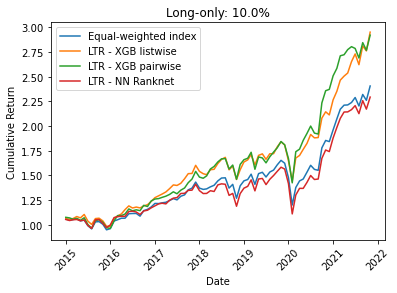

In [689]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
pct = 0.1
is_short = False
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(ltr_listwise, x_validate, df_validate,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

returns_matrix_pw, weight_matrix_pw, rank_table_pw, model_output_pw = get_Matrices(ltr_pairwise, x_validate, df_validate,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pw, cumrets_pw = calc_returns(returns_matrix_pw, weight_matrix = weight_matrix_pw, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(ltr_listwise, x_validate, df_validate,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

cumrets_rn = pd.read_pickle("cumrets_LTRvalid.pkl")
rets_rn = pd.read_pickle("rets_LTRvalid.pkl")
cumrets_equal = pd.read_pickle("cumrets_EQUALvalid.pkl")
rets_equal = pd.read_pickle("rets_EQUALvalid.pkl")

#rets.to_pickle("RetSeries/rets_XGBlistwise_valid.pkl")
#cumrets.to_pickle("RetSeries/cumrets_XGBlistwise_valid.pkl")
#rets_pw.to_pickle("RetSeries/rets_XGBpairwise_valid.pkl")
#cumrets_pw.to_pickle("RetSeries/cumrets_XGBpairwise_valid.pkl")

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "LTR - XGB listwise")
plt.plot(cumrets_pw.index, cumrets_pw, label = "LTR - XGB pairwise")
plt.plot(cumrets_rn.index, cumrets_rn, label = "LTR - NN Ranknet")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return")
#plt.yscale("log")
plt.title("Long-only: " + str(pct*100) + "%");

In [690]:
#sharpe ratio
mar = calc_mar(rets)
print("XGB_lw mar: ", mar)
sharpe = calc_sharpe(rets)
print("XGB_lw sharpe: ", sharpe)
sortino = calc_sortino(rets)
print("XGB_lw sortino: ", sortino)
mdd = calc_mdd(rets)
print("XGB_lw mdd: ", mdd[0])
print()

mar = calc_mar(rets_pw)
print("XGB_pw mar: ", mar)
sharpe = calc_sharpe(rets_pw)
print("XGB_pw sharpe: ", sharpe)
sortino = calc_sortino(rets_pw)
print("XGB_pw sortino: ", sortino)
mdd = calc_mdd(rets_pw)
print("XGB_pw mdd: ", mdd[0])
print()

mar = calc_mar(rets_rn)
print("LTR_rn mar: ", mar)
sharpe = calc_sharpe(rets_rn)
print("LTR_rn sharpe: ", sharpe)
sortino = calc_sortino(rets_rn)
print("LTR_rn sortino: ", sortino)
mdd = calc_mdd(rets_rn)
print("LTR_rn mdd: ", mdd[0])
print()

mar_equal = calc_mar(rets_equal)
print("Base index mar: ", mar_equal)
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
sortino_equal = calc_sortino(rets_equal)
print("NN sortino (ls): ", sortino_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

XGB_lw mar:  0.18211195359828602
XGB_lw sharpe:  1.2196416994016108
XGB_lw sortino:  1.623246147800743
XGB_lw mdd:  0.2165453975685545

XGB_pw mar:  0.18488693501360398
XGB_pw sharpe:  1.0531627178940173
XGB_pw sortino:  1.5257935966189924
XGB_pw mdd:  0.22699499987837368

LTR_rn mar:  0.14576555662887114
LTR_rn sharpe:  0.8123389656493564
LTR_rn sortino:  0.915508579556583
LTR_rn mdd:  0.29854056746597135

Base index mar:  0.15085864682089722
Base index sharpe:  0.9110410369122878
NN sortino (ls):  1.0435383797657294
Base index mdd:  0.2736139104787979


## 6c) Plot

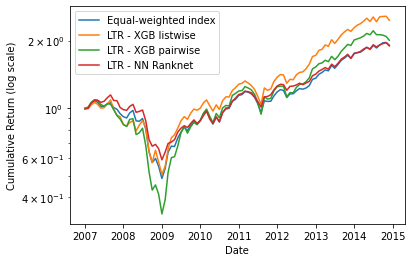

In [38]:
cumrets_rn = pd.read_pickle("cumrets_LTRtest.pkl")
rets_rn = pd.read_pickle("rets_LTRtest.pkl")
cumrets_equal = pd.read_pickle("cumrets_equal.pkl")
rets_equal = pd.read_pickle("rets_equal.pkl")

rets= pd.read_pickle("RetSeries/rets_XGBlistwise_test.pkl")
cumrets= pd.read_pickle("RetSeries/cumrets_XGBlistwise_test.pkl")
rets_pw= pd.read_pickle("RetSeries/rets_XGBpairwise_test.pkl")
cumrets_pw= pd.read_pickle("RetSeries/cumrets_XGBpairwise_test.pkl")

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "LTR - XGB listwise")
plt.plot(cumrets_pw.index, cumrets_pw, label = "LTR - XGB pairwise")
plt.plot(cumrets_rn.index, cumrets_rn, label = "LTR - NN Ranknet")
plt.legend();
plt.xlabel("Date");
#plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return (log scale)")
plt.yscale("log")
#plt.title("Long-only: " + str(pct*100) + "%");
plt.savefig("Figures/TL_TestLTR_Cumrets.png", bbox_inches = "tight")

In [738]:
#sharpe ratio
mar = calc_mar(rets)
print("XGB_lw mar: ", mar)
sharpe = calc_sharpe(rets)
print("XGB_lw sharpe: ", sharpe)
sortino = calc_sortino(rets)
print("XGB_lw sortino: ", sortino)
mdd = calc_mdd(rets)
print("XGB_lw mdd: ", mdd[0])
print()

mar = calc_mar(rets_pw)
print("XGB_pw mar: ", mar)
sharpe = calc_sharpe(rets_pw)
print("XGB_pw sharpe: ", sharpe)
sortino = calc_sortino(rets_pw)
print("XGB_pw sortino: ", sortino)
mdd = calc_mdd(rets_pw)
print("XGB_pw mdd: ", mdd[0])
print()

mar = calc_mar(rets_rn)
print("LTR_rn mar: ", mar)
sharpe = calc_sharpe(rets_rn)
print("LTR_rn sharpe: ", sharpe)
sortino = calc_sortino(rets_rn)
print("LTR_rn sortino: ", sortino)
mdd = calc_mdd(rets_rn)
print("LTR_rn mdd: ", mdd[0])
print()

mar_equal = calc_mar(rets_equal)
print("Base index mar: ", mar_equal)
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
sortino_equal = calc_sortino(rets_equal)
print("NN sortino (ls): ", sortino_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

XGB_lw mar:  0.1451493901330161
XGB_lw sharpe:  0.6741668203199954
XGB_lw sortino:  0.9514264328508532
XGB_lw mdd:  0.5343757439890374

XGB_pw mar:  0.13075175109585957
XGB_pw sharpe:  0.48235731376418767
XGB_pw sortino:  0.6571742888761747
XGB_pw mdd:  0.6899229999602551

LTR_rn mar:  0.09708234356751522
LTR_rn sharpe:  0.6063074037638636
LTR_rn sortino:  0.7578721816576092
LTR_rn mdd:  0.48627265306911494

Base index mar:  0.10435288132663723
Base index sharpe:  0.5413739461084112
NN sortino (ls):  0.7004685924153446
Base index mdd:  0.5503925391111795


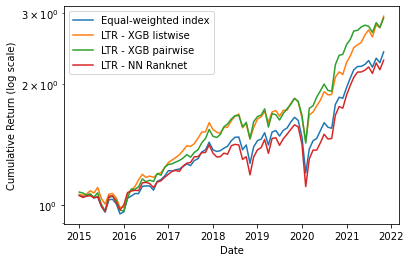

In [41]:
cumrets_rn = pd.read_pickle("cumrets_LTRvalid.pkl")
rets_rn = pd.read_pickle("rets_LTRvalid.pkl")
cumrets_equal = pd.read_pickle("cumrets_EQUALvalid.pkl")
rets_equal = pd.read_pickle("rets_EQUALvalid.pkl")

rets= pd.read_pickle("RetSeries/rets_XGBlistwise_valid.pkl")
cumrets= pd.read_pickle("RetSeries/cumrets_XGBlistwise_valid.pkl")
rets_pw= pd.read_pickle("RetSeries/rets_XGBpairwise_valid.pkl")
cumrets_pw= pd.read_pickle("RetSeries/cumrets_XGBpairwise_valid.pkl")

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "LTR - XGB listwise")
plt.plot(cumrets_pw.index, cumrets_pw, label = "LTR - XGB pairwise")
plt.plot(cumrets_rn.index, cumrets_rn, label = "LTR - NN Ranknet")
plt.legend();
plt.xlabel("Date");
#plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return (log scale)")
plt.yscale("log")
#plt.title("Long-only: " + str(pct*100) + "%");
#plt.savefig("Figures/TL_ValidLTR_Cumrets.png", bbox_inches = "tight")

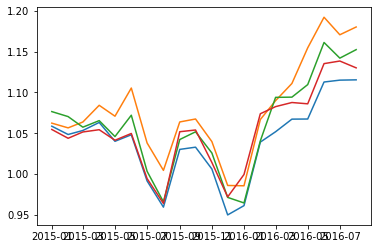

In [44]:
n_cut = 20
plt.plot(cumrets_equal.index[:n_cut], cumrets_equal[:n_cut], label = "Equal-weighted index")
plt.plot(cumrets.index[:n_cut], cumrets[:n_cut], label = "LTR - XGB listwise")
plt.plot(cumrets_pw.index[:n_cut], cumrets_pw[:n_cut], label = "LTR - XGB pairwise")
plt.plot(cumrets_rn.index[:n_cut], cumrets_rn[:n_cut], label = "LTR - NN Ranknet")

In [740]:
#sharpe ratio
mar = calc_mar(rets)
print("XGB_lw mar: ", mar)
sharpe = calc_sharpe(rets)
print("XGB_lw sharpe: ", sharpe)
sortino = calc_sortino(rets)
print("XGB_lw sortino: ", sortino)
mdd = calc_mdd(rets)
print("XGB_lw mdd: ", mdd[0])
print()

mar = calc_mar(rets_pw)
print("XGB_pw mar: ", mar)
sharpe = calc_sharpe(rets_pw)
print("XGB_pw sharpe: ", sharpe)
sortino = calc_sortino(rets_pw)
print("XGB_pw sortino: ", sortino)
mdd = calc_mdd(rets_pw)
print("XGB_pw mdd: ", mdd[0])
print()

mar = calc_mar(rets_rn)
print("LTR_rn mar: ", mar)
sharpe = calc_sharpe(rets_rn)
print("LTR_rn sharpe: ", sharpe)
sortino = calc_sortino(rets_rn)
print("LTR_rn sortino: ", sortino)
mdd = calc_mdd(rets_rn)
print("LTR_rn mdd: ", mdd[0])
print()

mar_equal = calc_mar(rets_equal)
print("Base index mar: ", mar_equal)
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
sortino_equal = calc_sortino(rets_equal)
print("NN sortino (ls): ", sortino_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

XGB_lw mar:  0.18211195359828602
XGB_lw sharpe:  1.2196416994016108
XGB_lw sortino:  1.623246147800743
XGB_lw mdd:  0.2165453975685545

XGB_pw mar:  0.18488693501360398
XGB_pw sharpe:  1.0531627178940173
XGB_pw sortino:  1.5257935966189924
XGB_pw mdd:  0.22699499987837368

LTR_rn mar:  0.14576555662887114
LTR_rn sharpe:  0.8123389656493564
LTR_rn sortino:  0.915508579556583
LTR_rn mdd:  0.29854056746597135

Base index mar:  0.15085864682089722
Base index sharpe:  0.9110410369122878
NN sortino (ls):  1.0435383797657294
Base index mdd:  0.2736139104787979


## 6d) LTR plots for website

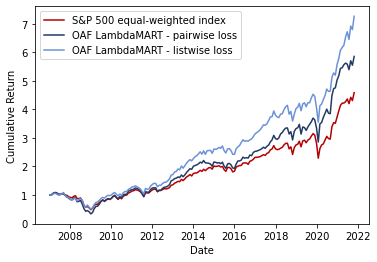

In [748]:
cumrets_equal1 = pd.read_pickle("cumrets_equal.pkl")
rets_equal1 = pd.read_pickle("rets_equal.pkl")

rets1= pd.read_pickle("RetSeries/rets_XGBlistwise_test.pkl")
cumrets1= pd.read_pickle("RetSeries/cumrets_XGBlistwise_test.pkl")
rets_pw1= pd.read_pickle("RetSeries/rets_XGBpairwise_test.pkl")
cumrets_pw1= pd.read_pickle("RetSeries/cumrets_XGBpairwise_test.pkl")

cumrets_equal2 = pd.read_pickle("cumrets_EQUALvalid.pkl")
rets_equal2 = pd.read_pickle("rets_EQUALvalid.pkl")

rets2= pd.read_pickle("RetSeries/rets_XGBlistwise_valid.pkl")
cumrets2= pd.read_pickle("RetSeries/cumrets_XGBlistwise_valid.pkl")
rets_pw2= pd.read_pickle("RetSeries/rets_XGBpairwise_valid.pkl")
cumrets_pw2= pd.read_pickle("RetSeries/cumrets_XGBpairwise_valid.pkl")

cumrets_equal2 *= cumrets_equal1[-1]
cumrets2 *= cumrets1[-1]
cumrets_pw2 *= cumrets_pw1[-1]

cumrets_oaf_pw = pd.concat([cumrets_pw1, cumrets_pw2], axis = 0)
cumrets_oaf_lw = pd.concat([cumrets1, cumrets2], axis = 0)
cumrets_snp = pd.concat([cumrets_equal1, cumrets_equal2], axis = 0)
plt.plot(cumrets_snp.index, cumrets_snp, label = "S&P 500 equal-weighted index", color = "#b40000")
plt.plot(cumrets_oaf_pw.index, cumrets_oaf_pw, label = "OAF LambdaMART - pairwise loss", color = "#223963")
plt.plot(cumrets_oaf_lw.index, cumrets_oaf_lw, label = "OAF LambdaMART - listwise loss", color = "#6b92d7")
plt.legend();
plt.xlabel("Date");
#plt.xticks(rotation = 45);
#plt.yscale("log")
plt.ylabel("Cumulative Return")
plt.savefig("Figures/OAF_LTR_Info.png")

#red: #b40000 - use this for s&p
#dark blue: #223963
#light blue: #6b92d7
#green: #398e64
#yellow: #e5b200

In [742]:
rets_oaf_pw = pd.concat([rets_pw1, rets_pw2], axis = 0)
rets_oaf_lw = pd.concat([rets1, rets2], axis = 0)
rets_snp = pd.concat([rets_equal1, rets_equal2], axis = 0)

print(calc_sharpe(rets_snp))
print(calc_sharpe(rets_oaf_pw))
print(calc_sharpe(rets_oaf_lw))

print()
print(calc_sortino(rets_snp))
print(calc_sortino(rets_oaf_pw))
print(calc_sortino(rets_oaf_lw))

0.6972758836262212
0.6728176990468021
0.8663523503519777

0.86000000353002
0.8963397977733732
1.165617419330458


## 6e) Plots for all validation strats

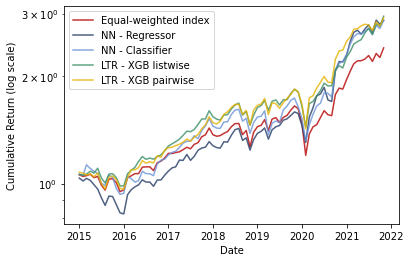

In [81]:
cumrets_rn = pd.read_pickle("cumrets_LTRvalid.pkl")
rets_rn = pd.read_pickle("rets_LTRvalid.pkl")
cumrets_equal = pd.read_pickle("cumrets_EQUALvalid.pkl")
rets_equal = pd.read_pickle("rets_EQUALvalid.pkl")

rets= pd.read_pickle("RetSeries/rets_XGBlistwise_valid.pkl")
cumrets= pd.read_pickle("RetSeries/cumrets_XGBlistwise_valid.pkl")
rets_pw= pd.read_pickle("RetSeries/rets_XGBpairwise_valid.pkl")
cumrets_pw= pd.read_pickle("RetSeries/cumrets_XGBpairwise_valid.pkl")

rets_reg= pd.read_pickle("RetSeries/rets_NNreg_valid.pkl")
cumrets_reg= pd.read_pickle("RetSeries/cumrets_NNreg_valid.pkl")
rets_clf= pd.read_pickle("RetSeries/rets_NNclf_valid.pkl")
cumrets_clf= pd.read_pickle("RetSeries/cumrets_NNclf_valid.pkl")

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index", color = "#b40000", alpha = 0.8)
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - Regressor", color = "#223963", alpha = 0.8)
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - Classifier", color = "#6b92d7", alpha = 0.8)
plt.plot(cumrets.index, cumrets, label = "LTR - XGB listwise", color = "#398e64", alpha = 0.8)
plt.plot(cumrets_pw.index, cumrets_pw, label = "LTR - XGB pairwise", color = "#e5b200", alpha = 0.8)

plt.legend();
plt.xlabel("Date");
#plt.xticks(rotation = 45);
plt.ylabel("Cumulative Return (log scale)")
plt.yscale("log")
#plt.title("Long-only: " + str(pct*100) + "%");
plt.savefig("Figures/TL_ValidAll.png", bbox_inches = "tight")